In [2]:
import requests
import json
import os
import time
from pathlib import Path
import pandas as pd

class TCGAWSIDownloader:
    def __init__(self, download_dir="tcga_brca_wsi"):
        self.base_url = "https://api.gdc.cancer.gov"
        self.download_dir = Path(download_dir)
        self.download_dir.mkdir(exist_ok=True)
        
    def query_wsi_files(self, max_files=None):
        """Query GDC API for TCGA-BRCA WSI files"""
        
        # Define filters for TCGA-BRCA WSI files
        filters = {
            "op": "and",
            "content": [
                {
                    "op": "in",
                    "content": {
                        "field": "cases.project.project_id",
                        "value": ["TCGA-BRCA"]
                    }
                },
                {
                    "op": "in", 
                    "content": {
                        "field": "files.data_category",
                        "value": ["Biospecimen"]
                    }
                },
                {
                    "op": "in",
                    "content": {
                        "field": "files.data_type", 
                        "value": ["Slide Image"]
                    }
                },
                {
                    "op": "in",
                    "content": {
                        "field": "files.experimental_strategy",
                        "value": ["Tissue Slide"]
                    }
                }
            ]
        }
        
        # Parameters for the API request
        params = {
            "filters": json.dumps(filters),
            "expand": "cases.project,cases.submitter_id",
            "fields": "file_id,file_name,file_size,cases.submitter_id,cases.project.project_id",
            "format": "json",
            "size": str(max_files) if max_files else "2000"
        }
        
        print("Querying GDC API for TCGA-BRCA WSI files...")
        response = requests.get(f"{self.base_url}/files", params=params)
        response.raise_for_status()
        
        data = response.json()
        files_info = data["data"]["hits"]
        
        print(f"Found {len(files_info)} WSI files")
        return files_info
    
    def create_file_manifest(self, files_info, manifest_path="wsi_manifest.tsv"):
        """Create a manifest file with file information"""
        
        manifest_data = []
        for file_info in files_info:
            case_id = file_info["cases"][0]["submitter_id"] if file_info["cases"] else "Unknown"
            manifest_data.append({
                "file_id": file_info["file_id"],
                "filename": file_info["file_name"],
                "file_size_mb": round(file_info["file_size"] / (1024*1024), 2),
                "case_id": case_id,
                "project": file_info["cases"][0]["project"]["project_id"] if file_info["cases"] else "Unknown"
            })
        
        df = pd.DataFrame(manifest_data)
        df.to_csv(self.download_dir / manifest_path, sep='\t', index=False)
        print(f"Manifest saved to {self.download_dir / manifest_path}")
        return df
    
    def download_file(self, file_id, filename):
        """Download a single file from GDC"""
        
        file_path = self.download_dir / filename
        
        # Skip if file already exists
        if file_path.exists():
            print(f"File {filename} already exists, skipping...")
            return True
        
        print(f"Downloading {filename}...")
        
        # Download the file
        download_url = f"{self.base_url}/data/{file_id}"
        
        try:
            response = requests.get(download_url, stream=True)
            response.raise_for_status()
            
            total_size = int(response.headers.get('content-length', 0))
            downloaded = 0
            
            with open(file_path, 'wb') as f:
                for chunk in response.iter_content(chunk_size=8192):
                    if chunk:
                        f.write(chunk)
                        downloaded += len(chunk)
                        
                        # Print progress for large files
                        if total_size > 0:
                            progress = (downloaded / total_size) * 100
                            print(f"\rProgress: {progress:.1f}%", end='', flush=True)
            
            print(f"\n✓ Downloaded {filename}")
            return True
            
        except Exception as e:
            print(f"\n✗ Error downloading {filename}: {str(e)}")
            # Remove partial file if it exists
            if file_path.exists():
                file_path.unlink()
            return False
    
    def download_wsi_files(self, max_files=10, delay=1):
        """Download WSI files with rate limiting"""
        
        # Query for files
        files_info = self.query_wsi_files(max_files)
        
        if not files_info:
            print("No WSI files found!")
            return
        
        # Create manifest
        manifest_df = self.create_file_manifest(files_info)
        
        print(f"\nStarting download of {len(files_info)} files...")
        print(f"Total size: {manifest_df['file_size_mb'].sum():.2f} MB")
        
        successful_downloads = 0
        failed_downloads = 0
        
        for i, file_info in enumerate(files_info, 1):
            file_id = file_info["file_id"]
            filename = file_info["file_name"]
            
            print(f"\n[{i}/{len(files_info)}] ", end='')
            
            if self.download_file(file_id, filename):
                successful_downloads += 1
            else:
                failed_downloads += 1
            
            # Rate limiting
            if i < len(files_info):
                time.sleep(delay)
        
        print(f"\n\nDownload Summary:")
        print(f"✓ Successful: {successful_downloads}")
        print(f"✗ Failed: {failed_downloads}")
        print(f"📁 Files saved to: {self.download_dir}")

# Example usage
if __name__ == "__main__":
    # Initialize downloader
    downloader = TCGAWSIDownloader(download_dir="tcga_brca_wsi")
    
    # Download first 5 WSI files (adjust max_files as needed)
    # Note: WSI files are very large (100MB - 2GB each)
    downloader.download_wsi_files(max_files=5, delay=2)
    
    # Alternative: Just query and create manifest without downloading
    # files_info = downloader.query_wsi_files(max_files=100)
    # manifest_df = downloader.create_file_manifest(files_info)
    # print(manifest_df.head())

Querying GDC API for TCGA-BRCA WSI files...
Found 5 WSI files
Manifest saved to tcga_brca_wsi/wsi_manifest.tsv

Starting download of 5 files...
Total size: 1023.95 MB

[1/5] Downloading TCGA-C8-A27B-01A-01-TSA.b93af347-1b83-4284-afaf-b3c14d8e038b.svs...
Progress: 6.8%

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Progress: 16.1%

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Progress: 25.8%

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Progress: 35.3%

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Progress: 45.1%

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Progress: 54.3%

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Progress: 63.8%

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Progress: 73.4%

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Progress: 82.6%

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Progress: 92.2%

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Progress: 100.0%
✓ Downloaded TCGA-C8-A27B-01A-01-TSA.b93af347-1b83-4284-afaf-b3c14d8e038b.svs

[2/5] Downloading TCGA-E9-A1R0-01A-02-TSB.76d55fb8-5518-496c-9a80-de81a3073232.svs...
Progress: 13.6%

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Progress: 33.3%

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Progress: 53.4%

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Progress: 73.9%

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Progress: 93.9%

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)




✓ Downloaded TCGA-E9-A1R0-01A-02-TSB.76d55fb8-5518-496c-9a80-de81a3073232.svs

[3/5] Downloading TCGA-EW-A1IZ-01A-01-TSA.a52af132-ed54-40a0-931b-913928cf057f.svs...
Progress: 16.1%

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Progress: 38.8%

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Progress: 62.0%

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Progress: 85.1%

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Progress: 100.0%
✓ Downloaded TCGA-EW-A1IZ-01A-01-TSA.a52af132-ed54-40a0-931b-913928cf057f.svs

[4/5] Downloading TCGA-OL-A5D6-01A-02-TSB.9E12E9C6-91FD-4CED-B469-37D7A88026D1.svs...
Progress: 9.3%

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Progress: 23.4%

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Progress: 37.8%

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Progress: 51.9%

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Progress: 66.2%

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Progress: 79.9%

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Progress: 94.2%

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Progress: 100.0%
✓ Downloaded TCGA-OL-A5D6-01A-02-TSB.9E12E9C6-91FD-4CED-B469-37D7A88026D1.svs

[5/5] Downloading TCGA-D8-A27P-01A-01-TSA.df327c6c-1fde-4c29-ad33-de4b8420170f.svs...
Progress: 25.7%

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Progress: 64.1%

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Progress: 100.0%
✓ Downloaded TCGA-D8-A27P-01A-01-TSA.df327c6c-1fde-4c29-ad33-de4b8420170f.svs


Download Summary:
✓ Successful: 5
✗ Failed: 0
📁 Files saved to: tcga_brca_wsi


Found 5 WSI files
=== Exploring WSI Properties ===

=== WSI Properties for TCGA-C8-A27B-01A-01-TSA.b93af347-1b83-4284-afaf-b3c14d8e038b.svs ===
Dimensions: (79016, 39012)
Level count: 4
Level dimensions: ((79016, 39012), (19754, 9753), (4938, 2438), (2469, 1219))
Level downsamples: (1.0, 4.0, 16.00163038909716, 32.00326077819432)
Objective power: 40
MPP X: 0.24560000000000001
MPP Y: 0.24560000000000001

=== Creating Dataset Summary ===
                                            filename  width  height  \
0  TCGA-C8-A27B-01A-01-TSA.b93af347-1b83-4284-afa...  79016   39012   
1  TCGA-OL-A5D6-01A-02-TSB.9E12E9C6-91FD-4CED-B46...  83776   30683   
2  TCGA-EW-A1IZ-01A-01-TSA.a52af132-ed54-40a0-931...  76159   28250   
3  TCGA-E9-A1R0-01A-02-TSB.76d55fb8-5518-496c-9a8...  73304   25281   
4  TCGA-D8-A27P-01A-01-TSA.df327c6c-1fde-4c29-ad3...  55215   21158   

   file_size_mb  tissue_ratio  total_pixels  case_id  
0        359.88         0.226    3082572192  C8-A27B  
1        251.00        

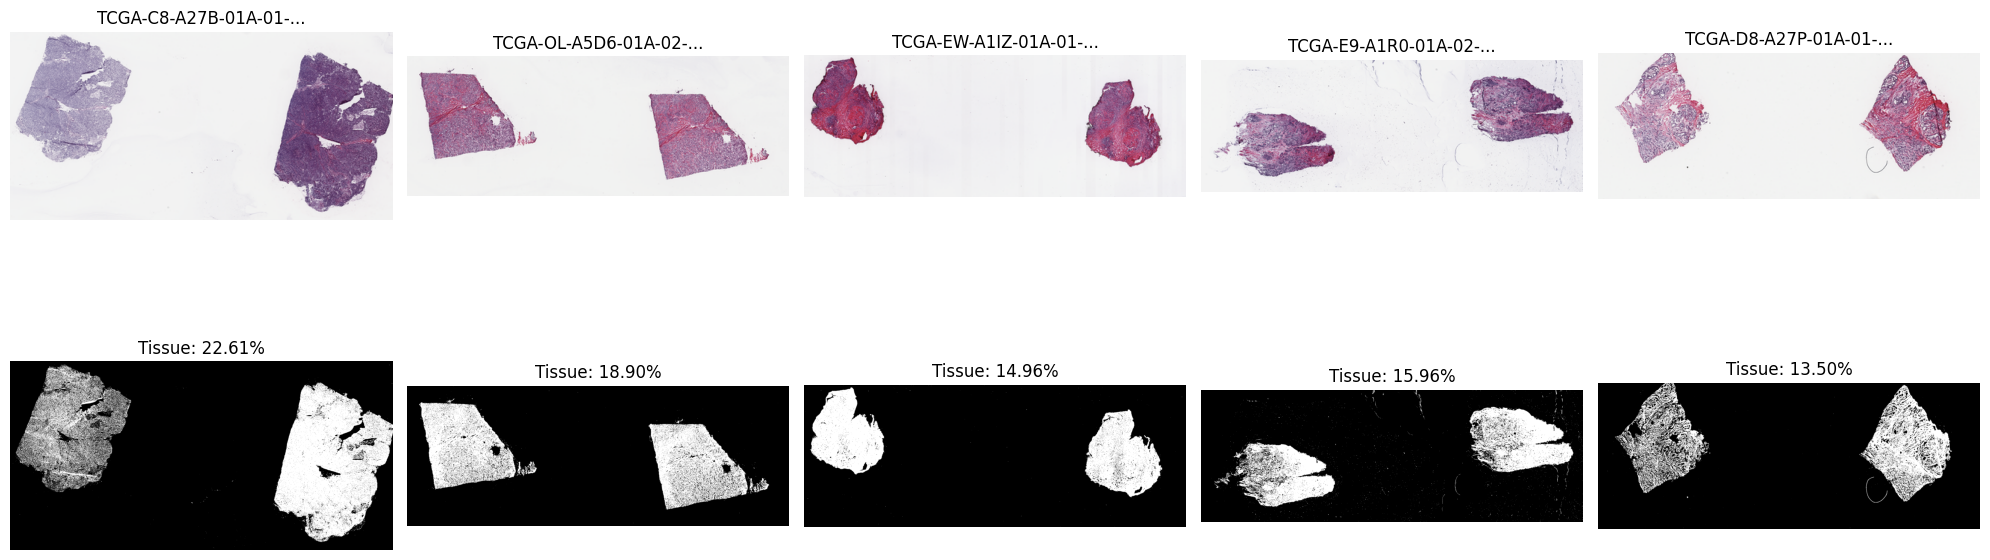


=== Extracting Sample Patches ===
Extracted 10 patches


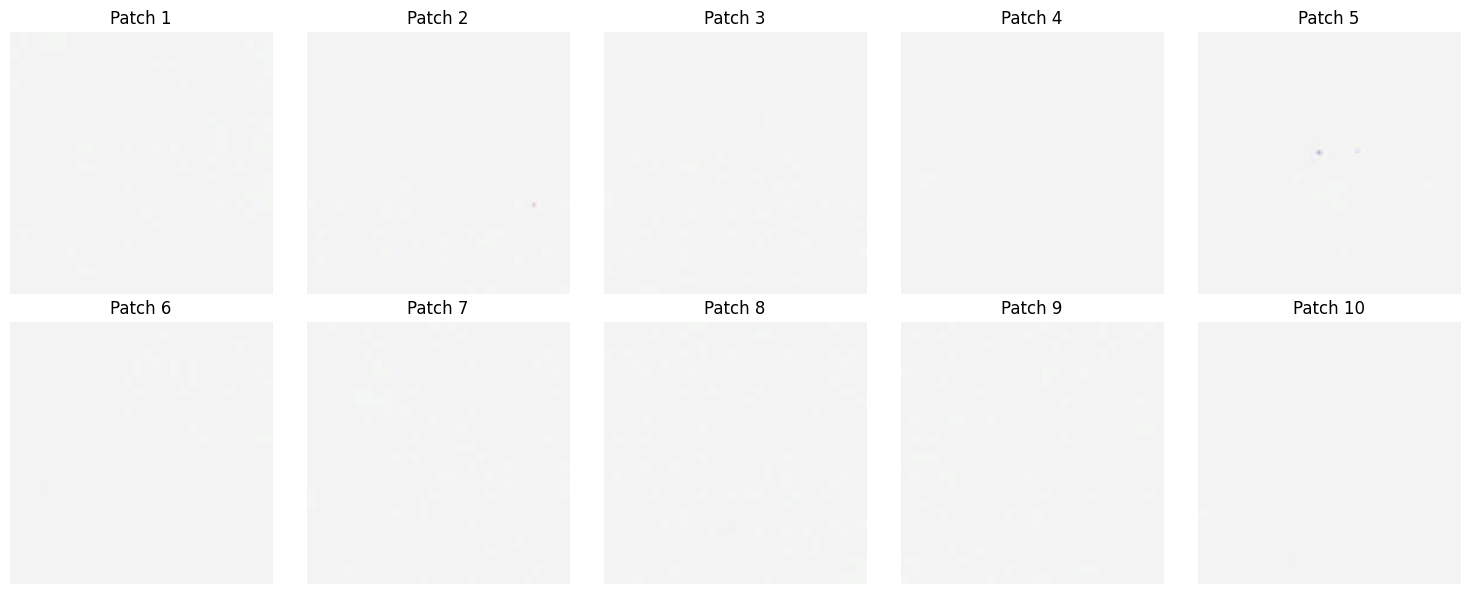

In [8]:
import openslide
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd
from pathlib import Path
import seaborn as sns

class WSIAnalyzer:
    def __init__(self, wsi_dir="tcga_brca_wsi"):
        self.wsi_dir = Path(wsi_dir)
        self.wsi_files = list(self.wsi_dir.glob("*.svs"))
        print(f"Found {len(self.wsi_files)} WSI files")
        
    def explore_wsi_properties(self, wsi_path):
        """Explore basic properties of a WSI file"""
        try:
            slide = openslide.OpenSlide(str(wsi_path))
            
            print(f"\n=== WSI Properties for {wsi_path.name} ===")
            print(f"Dimensions: {slide.dimensions}")
            print(f"Level count: {slide.level_count}")
            print(f"Level dimensions: {slide.level_dimensions}")
            print(f"Level downsamples: {slide.level_downsamples}")
            print(f"Objective power: {slide.properties.get('openslide.objective-power', 'N/A')}")
            print(f"MPP X: {slide.properties.get('openslide.mpp-x', 'N/A')}")
            print(f"MPP Y: {slide.properties.get('openslide.mpp-y', 'N/A')}")
            
            slide.close()
            return True
        except Exception as e:
            print(f"Error reading {wsi_path.name}: {e}")
            return False
    
    def extract_thumbnail(self, wsi_path, size=(512, 512)):
        """Extract thumbnail from WSI"""
        try:
            slide = openslide.OpenSlide(str(wsi_path))
            
            # Get thumbnail
            thumbnail = slide.get_thumbnail(size)
            
            slide.close()
            return np.array(thumbnail)
        except Exception as e:
            print(f"Error extracting thumbnail from {wsi_path.name}: {e}")
            return None
    
    def extract_tissue_region(self, wsi_path, level=6, threshold=0.8):
        """Extract tissue regions using Otsu thresholding"""
        try:
            slide = openslide.OpenSlide(str(wsi_path))
            
            # Read at lower resolution for tissue detection
            if level >= slide.level_count:
                level = slide.level_count - 1
                
            # Read the entire slide at low resolution
            low_res = slide.read_region((0, 0), level, slide.level_dimensions[level])
            low_res = np.array(low_res.convert('RGB'))
            
            # Convert to grayscale
            gray = cv2.cvtColor(low_res, cv2.COLOR_RGB2GRAY)
            
            # Apply Otsu thresholding
            _, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
            
            # Invert to get tissue regions (tissue is darker)
            tissue_mask = 255 - binary
            
            # Calculate tissue percentage
            tissue_ratio = np.sum(tissue_mask > 0) / tissue_mask.size
            
            slide.close()
            return tissue_mask, tissue_ratio
            
        except Exception as e:
            print(f"Error processing tissue regions in {wsi_path.name}: {e}")
            return None, 0
    
    def extract_patches(self, wsi_path, patch_size=224, level=0, stride=None, max_patches=100):
        """Extract patches from tissue regions"""
        if stride is None:
            stride = patch_size
            
        try:
            slide = openslide.OpenSlide(str(wsi_path))
            
            # Get tissue mask at lower resolution
            tissue_mask, _ = self.extract_tissue_region(wsi_path)
            if tissue_mask is None:
                return []
            
            # Calculate scaling factor between levels
            scale_factor = slide.level_downsamples[6] if 6 < slide.level_count else 1
            
            patches = []
            patch_coords = []
            
            # Generate patch coordinates
            height, width = tissue_mask.shape
            for y in range(0, height - patch_size//int(scale_factor), stride//int(scale_factor)):
                for x in range(0, width - patch_size//int(scale_factor), stride//int(scale_factor)):
                    
                    # Check if patch contains tissue
                    patch_mask = tissue_mask[y:y+patch_size//int(scale_factor), 
                                           x:x+patch_size//int(scale_factor)]
                    tissue_ratio = np.sum(patch_mask > 0) / patch_mask.size
                    
                    if tissue_ratio > 0.3:  # Threshold for tissue content
                        # Convert coordinates to original resolution
                        orig_x = int(x * scale_factor)
                        orig_y = int(y * scale_factor)
                        
                        # Extract patch at original resolution
                        patch = slide.read_region((orig_x, orig_y), level, (patch_size, patch_size))
                        patch = np.array(patch.convert('RGB'))
                        
                        patches.append(patch)
                        patch_coords.append((orig_x, orig_y))
                        
                        if len(patches) >= max_patches:
                            break
                if len(patches) >= max_patches:
                    break
            
            slide.close()
            return patches, patch_coords
            
        except Exception as e:
            print(f"Error extracting patches from {wsi_path.name}: {e}")
            return [], []
    
    def visualize_wsi_overview(self, max_slides=5):
        """Create overview visualization of WSI files"""
        fig, axes = plt.subplots(2, min(len(self.wsi_files), max_slides), 
                                figsize=(4*min(len(self.wsi_files), max_slides), 8))
        
        if len(self.wsi_files) == 1:
            axes = axes.reshape(-1, 1)
        
        for idx, wsi_path in enumerate(self.wsi_files[:max_slides]):
            # Extract thumbnail
            thumbnail = self.extract_thumbnail(wsi_path)
            
            # Extract tissue mask
            tissue_mask, tissue_ratio = self.extract_tissue_region(wsi_path)
            
            if thumbnail is not None:
                axes[0, idx].imshow(thumbnail)
                axes[0, idx].set_title(f"{wsi_path.stem[:20]}...")
                axes[0, idx].axis('off')
            
            if tissue_mask is not None:
                axes[1, idx].imshow(tissue_mask, cmap='gray')
                axes[1, idx].set_title(f"Tissue: {tissue_ratio:.2%}")
                axes[1, idx].axis('off')
        
        plt.tight_layout()
        plt.show()
    
    def create_dataset_summary(self):
        """Create summary statistics of the WSI dataset"""
        summary_data = []
        
        for wsi_path in self.wsi_files:
            try:
                slide = openslide.OpenSlide(str(wsi_path))
                
                # Extract basic info
                width, height = slide.dimensions
                file_size_mb = wsi_path.stat().st_size / (1024 * 1024)
                
                # Get tissue ratio
                _, tissue_ratio = self.extract_tissue_region(wsi_path)
                
                summary_data.append({
                    'filename': wsi_path.name,
                    'width': width,
                    'height': height,
                    'file_size_mb': round(file_size_mb, 2),
                    'tissue_ratio': round(tissue_ratio, 3),
                    'total_pixels': width * height,
                    'case_id': wsi_path.name.split('-')[1] + '-' + wsi_path.name.split('-')[2]
                })
                
                slide.close()
                
            except Exception as e:
                print(f"Error processing {wsi_path.name}: {e}")
        
        df = pd.DataFrame(summary_data)
        return df

# Example usage
if __name__ == "__main__":
    # Initialize analyzer
    analyzer = WSIAnalyzer("tcga_brca_wsi")
    
    # Explore properties of first WSI
    if analyzer.wsi_files:
        print("=== Exploring WSI Properties ===")
        analyzer.explore_wsi_properties(analyzer.wsi_files[0])
        
        print("\n=== Creating Dataset Summary ===")
        summary_df = analyzer.create_dataset_summary()
        print(summary_df)
        
        print("\n=== Visualizing WSI Overview ===")
        analyzer.visualize_wsi_overview()
        
        print("\n=== Extracting Sample Patches ===")
        patches, coords = analyzer.extract_patches(analyzer.wsi_files[0], max_patches=10)
        print(f"Extracted {len(patches)} patches")
        
        # Visualize some patches
        if patches:
            fig, axes = plt.subplots(2, 5, figsize=(15, 6))
            for i, patch in enumerate(patches[:10]):
                row, col = i // 5, i % 5
                axes[row, col].imshow(patch)
                axes[row, col].set_title(f"Patch {i+1}")
                axes[row, col].axis('off')
            plt.tight_layout()
            plt.show()

Found 5 WSI files

Processing: TCGA-C8-A27B-01A-01-TSA.b93af347-1b83-4284-afaf-b3c14d8e038b.svs
Processing TCGA-C8-A27B-01A-01-TSA.b93af347-1b83-4284-afaf-b3c14d8e038b.svs: 79016x39012 at level 0
Potential patches: 186648


Extracting patches: 100%|█████████████████████| 500/500 [00:09<00:00, 53.48it/s]


Extracted 500 high-quality patches

Processing: TCGA-OL-A5D6-01A-02-TSB.9E12E9C6-91FD-4CED-B469-37D7A88026D1.svs
Processing TCGA-OL-A5D6-01A-02-TSB.9E12E9C6-91FD-4CED-B469-37D7A88026D1.svs: 83776x30683 at level 0
Potential patches: 155414


Extracting patches: 100%|█████████████████████| 500/500 [00:16<00:00, 29.65it/s]


Extracted 500 high-quality patches

Processing: TCGA-EW-A1IZ-01A-01-TSA.a52af132-ed54-40a0-931b-913928cf057f.svs
Processing TCGA-EW-A1IZ-01A-01-TSA.a52af132-ed54-40a0-931b-913928cf057f.svs: 76159x28250 at level 0
Potential patches: 129867


Extracting patches: 100%|█████████████████████| 500/500 [00:08<00:00, 60.44it/s]


Extracted 500 high-quality patches

Processing: TCGA-E9-A1R0-01A-02-TSB.76d55fb8-5518-496c-9a80-de81a3073232.svs
Processing TCGA-E9-A1R0-01A-02-TSB.76d55fb8-5518-496c-9a80-de81a3073232.svs: 73304x25281 at level 0
Potential patches: 111916


Extracting patches: 100%|█████████████████████| 500/500 [00:13<00:00, 36.07it/s]


Extracted 500 high-quality patches

Processing: TCGA-D8-A27P-01A-01-TSA.df327c6c-1fde-4c29-ad33-de4b8420170f.svs
Processing TCGA-D8-A27P-01A-01-TSA.df327c6c-1fde-4c29-ad33-de4b8420170f.svs: 55215x21158 at level 0
Potential patches: 70520


Extracting patches: 100%|█████████████████████| 500/500 [00:05<00:00, 86.13it/s]


Extracted 500 high-quality patches

PROCESSING COMPLETE
Total patches extracted: 7500
Metadata saved to: processed_patches/metadata/patch_metadata.csv
Patches saved to: processed_patches/patches


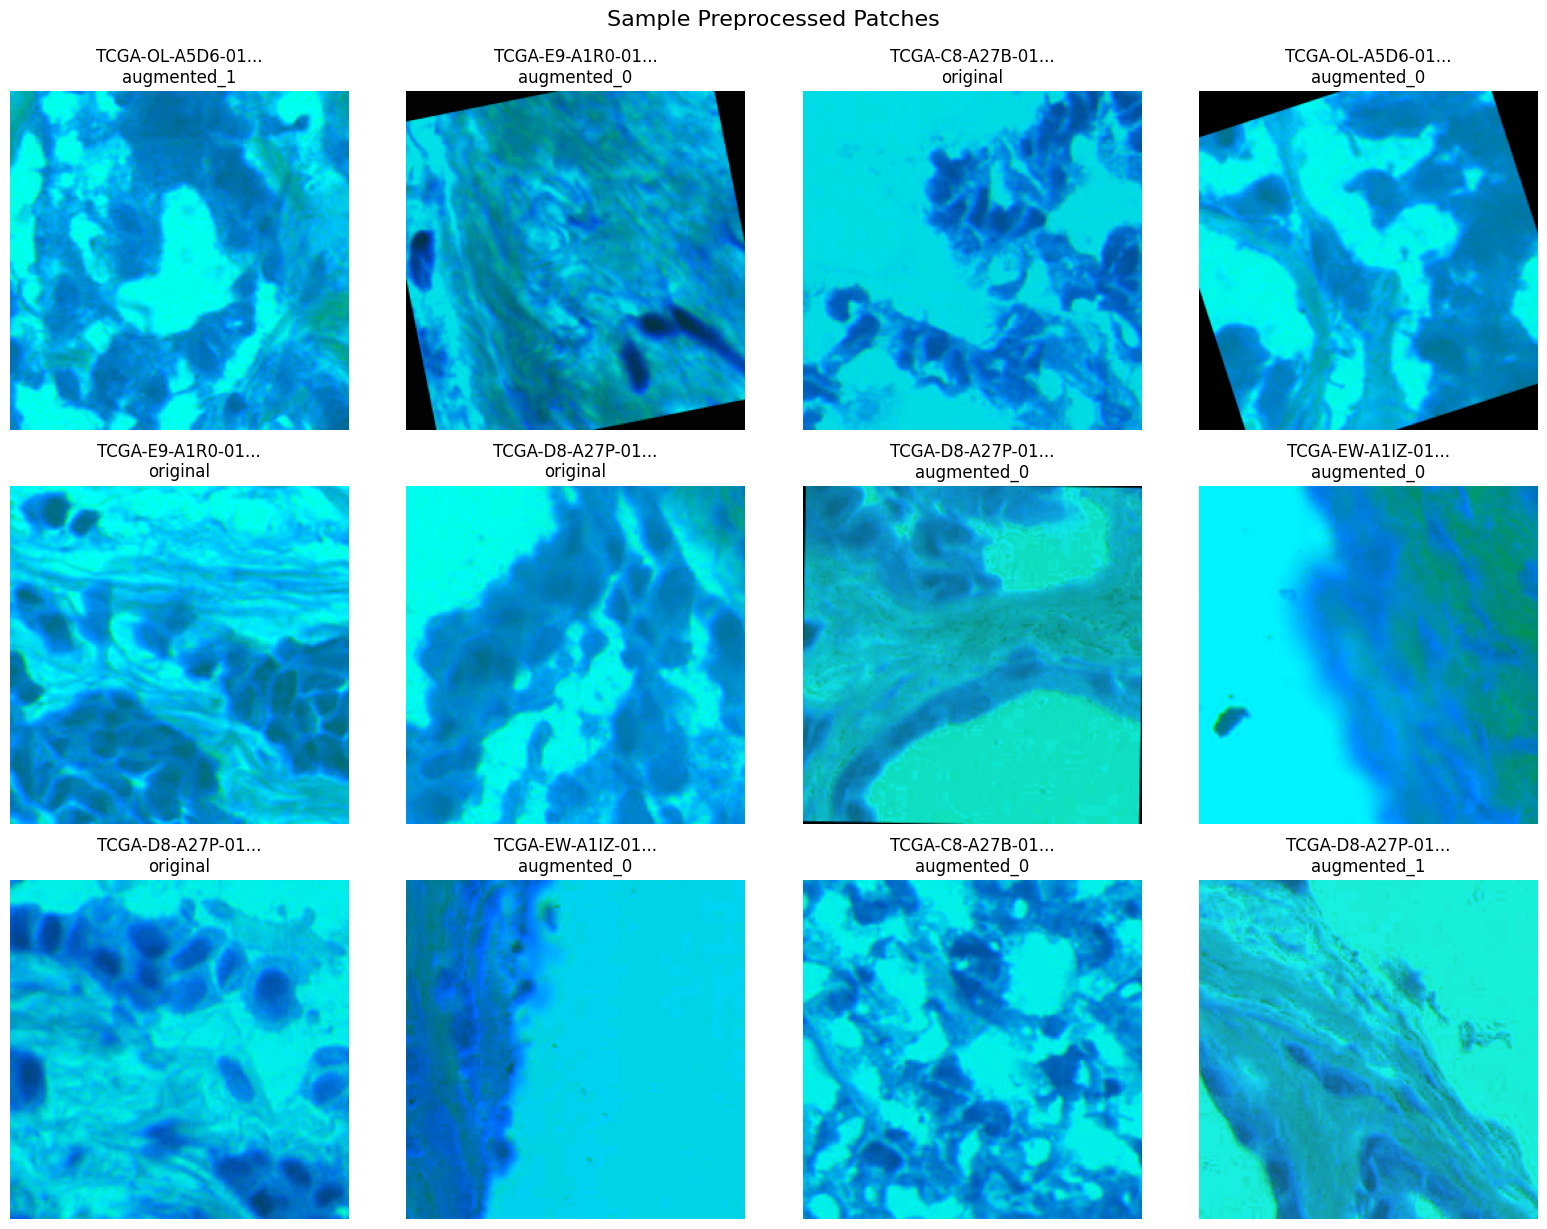


Dataset Summary:
Total patches: 7500
Original patches: 2500
Augmented patches: 5000
WSI files processed: 5

Patches per WSI:
wsi_file
TCGA-C8-A27B-01A-01-TSA.b93af347-1b83-4284-afaf-b3c14d8e038b.svs    1500
TCGA-OL-A5D6-01A-02-TSB.9E12E9C6-91FD-4CED-B469-37D7A88026D1.svs    1500
TCGA-EW-A1IZ-01A-01-TSA.a52af132-ed54-40a0-931b-913928cf057f.svs    1500
TCGA-E9-A1R0-01A-02-TSB.76d55fb8-5518-496c-9a80-de81a3073232.svs    1500
TCGA-D8-A27P-01A-01-TSA.df327c6c-1fde-4c29-ad33-de4b8420170f.svs    1500
Name: count, dtype: int64


In [16]:
import openslide
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image, ImageEnhance
import pandas as pd
from pathlib import Path
import pickle
import random
from sklearn.cluster import KMeans
from skimage import filters, morphology, measure
from skimage.color import rgb2hsv, hsv2rgb
import albumentations as A
try:
    from albumentations.pytorch import ToTensorV2
except ImportError:
    print("Warning: ToTensorV2 not available. Install albumentations with pytorch support.")
    ToTensorV2 = None
import json
import os
from tqdm import tqdm

class WSIPreprocessor:
    def __init__(self, wsi_dir="tcga_brca_wsi", output_dir="processed_patches", patch_size=256):
        self.wsi_dir = Path(wsi_dir)
        self.output_dir = Path(output_dir)
        self.patch_size = patch_size
        self.output_dir.mkdir(exist_ok=True)
        
        # Create subdirectories
        (self.output_dir / "patches").mkdir(exist_ok=True)
        (self.output_dir / "thumbnails").mkdir(exist_ok=True)
        (self.output_dir / "metadata").mkdir(exist_ok=True)
        
        self.wsi_files = list(self.wsi_dir.glob("*.svs"))
        print(f"Found {len(self.wsi_files)} WSI files")
        
        # Color normalization reference (you can update this with your own reference)
        self.color_norm_reference = None
        
    def detect_tissue_regions(self, image, method='otsu_hsv'):
        """
        Advanced tissue detection combining multiple methods
        """
        if method == 'otsu_hsv':
            # Convert to HSV for better tissue detection
            hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            
            # Create mask based on saturation and value
            # Tissue regions typically have higher saturation and lower value
            sat_mask = hsv[:, :, 1] > 20  # Saturation threshold
            val_mask = hsv[:, :, 2] < 240  # Value threshold (removes white background)
            
            # Combine masks
            tissue_mask = sat_mask & val_mask
            
            # Apply morphological operations to clean up
            kernel = np.ones((5, 5), np.uint8)
            tissue_mask = cv2.morphologyEx(tissue_mask.astype(np.uint8), cv2.MORPH_CLOSE, kernel)
            tissue_mask = cv2.morphologyEx(tissue_mask, cv2.MORPH_OPEN, kernel)
            
            return tissue_mask
            
        elif method == 'otsu_gray':
            # Convert to grayscale and apply Otsu thresholding
            gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
            _, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
            return 255 - binary  # Invert to get tissue regions
            
        elif method == 'rgb_threshold':
            # Simple RGB thresholding
            # Remove very bright pixels (background)
            mask = np.mean(image, axis=2) < 230
            return mask.astype(np.uint8) * 255
    
    def calculate_tissue_percentage(self, patch, threshold=0.3):
        """Calculate percentage of tissue in a patch"""
        tissue_mask = self.detect_tissue_regions(patch)
        tissue_ratio = np.sum(tissue_mask > 0) / tissue_mask.size
        return tissue_ratio > threshold
    
    def macenko_color_normalization(self, image, reference_stats=None):
        """
        Macenko color normalization for H&E stained slides
        Based on: "A method for normalizing histology slides for quantitative analysis"
        """
        # Convert to OD space
        image = image.astype(np.float64)
        image[image == 0] = 1  # Avoid log(0)
        od = -np.log(image / 255.0)
        
        # Remove transparent pixels
        od_hat = od[~np.any(od < 0.15, axis=2)]
        
        if len(od_hat) == 0:
            return image.astype(np.uint8)
        
        # Compute eigenvectors
        eigvals, eigvecs = np.linalg.eigh(np.cov(od_hat.T))
        
        # Project on the plane spanned by the eigenvectors corresponding to the two 
        # largest eigenvalues
        that = od_hat.dot(eigvecs[:, 1:3])
        
        phi = np.arctan2(that[:, 1], that[:, 0])
        
        minPhi = np.percentile(phi, 1)
        maxPhi = np.percentile(phi, 99)
        
        vMin = eigvecs[:, 1:3].dot(np.array([(np.cos(minPhi), np.sin(minPhi))]).T)
        vMax = eigvecs[:, 1:3].dot(np.array([(np.cos(maxPhi), np.sin(maxPhi))]).T)
        
        # Normalize stain concentrations
        if reference_stats is None:
            # Use default reference values for H&E
            HERef = np.array([[0.5626, 0.2159], [0.7201, 0.8012], [0.4062, 0.5581]])
            maxCRef = np.array([1.9705, 1.0308])
        else:
            HERef = reference_stats['HERef']
            maxCRef = reference_stats['maxCRef']
        
        # Estimate concentrations of the individual stains
        Y = np.reshape(od, (-1, 3)).T
        C = np.linalg.lstsq(np.concatenate((vMin, vMax), axis=1), Y, rcond=None)[0]
        maxC = np.array([np.percentile(C[0, :], 99), np.percentile(C[1, :], 99)])
        
        # Normalize concentrations
        C2 = C * (maxCRef / maxC)
        
        # Recreate the image using reference mixing matrix
        Inorm = np.multiply(255, np.exp(-HERef.dot(C2)))
        Inorm[Inorm > 255] = 255
        Inorm = np.reshape(Inorm.T, image.shape).astype(np.uint8)
        
        return Inorm
    
    def reinhard_color_normalization(self, image, target_means=None, target_stds=None):
        """
        Reinhard color normalization
        """
        if target_means is None:
            # Default values for H&E stained slides
            target_means = [148.60, 41.56, 81.48]  # Lab color space means
            target_stds = [41.56, 15.25, 21.25]   # Lab color space stds
        
        # Convert RGB to Lab
        lab = cv2.cvtColor(image, cv2.COLOR_RGB2LAB).astype(np.float64)
        
        # Calculate current means and stds
        current_means = [np.mean(lab[:, :, i]) for i in range(3)]
        current_stds = [np.std(lab[:, :, i]) for i in range(3)]
        
        # Normalize each channel
        for i in range(3):
            lab[:, :, i] = ((lab[:, :, i] - current_means[i]) * (target_stds[i] / current_stds[i])) + target_means[i]
        
        # Clip values to valid range
        lab = np.clip(lab, 0, 255)
        
        # Convert back to RGB
        normalized = cv2.cvtColor(lab.astype(np.uint8), cv2.COLOR_LAB2RGB)
        return normalized
    
    def create_training_pipeline(self, patch_size=256, mode='train'):
        """
        Create augmentation pipeline for model training with normalization
        """
        transforms_list = []
        
        if mode == 'train':
            transforms_list.extend([
                # Geometric transformations
                A.RandomRotate90(p=0.5),
                A.HorizontalFlip(p=0.5),
                A.VerticalFlip(p=0.5),
                A.Rotate(limit=45, p=0.3),
                
                # Color augmentations (mild for pathology)
                A.ColorJitter(
                    brightness=0.1,
                    contrast=0.1, 
                    saturation=0.1,
                    hue=0.05,
                    p=0.3
                ),
                
                # Blur and noise (very mild)
                A.OneOf([
                    A.GaussianBlur(blur_limit=3, p=0.1),
                    A.GaussNoise(var_limit=(0, 25), p=0.1),
                ], p=0.1),
            ])
        
        # Common transforms
        transforms_list.extend([
            A.Resize(patch_size, patch_size),
            A.Normalize(
                mean=[0.485, 0.456, 0.406],  # ImageNet means
                std=[0.229, 0.224, 0.225],   # ImageNet stds
                p=1.0
            ),
        ])
        
        # Add ToTensorV2 if available
        if ToTensorV2 is not None:
            transforms_list.append(ToTensorV2())
        
        return A.Compose(transforms_list)

    def create_augmentation_pipeline(self, patch_size=256):
        """
        Create augmentation pipeline optimized for pathology images
        """
        transform = A.Compose([
            # Geometric transformations
            A.RandomRotate90(p=0.5),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.Rotate(limit=45, p=0.3),
            
            # Color augmentations (mild for pathology)
            A.ColorJitter(
                brightness=0.1,
                contrast=0.1, 
                saturation=0.1,
                hue=0.05,
                p=0.3
            ),
            
            # Blur and noise (very mild)
            A.OneOf([
                A.GaussianBlur(blur_limit=3, p=0.1),
                A.GaussNoise(var_limit=(0, 25), p=0.1),
            ], p=0.1),
            
            # Ensure consistent output size
            A.Resize(patch_size, patch_size),
            
            # Normalization
            A.Normalize(
                mean=[0.485, 0.456, 0.406],  # ImageNet means
                std=[0.229, 0.224, 0.225],   # ImageNet stds
                p=1.0
            ),
        ])
        
        return transform
    
    def extract_patches_from_wsi(self, wsi_path, level=0, stride=None, 
                                tissue_threshold=0.3, max_patches_per_wsi=1000):
        """
        Extract patches from WSI with tissue detection and quality control
        """
        if stride is None:
            stride = self.patch_size // 2  # 50% overlap by default
        
        try:
            slide = openslide.OpenSlide(str(wsi_path))
            
            # Get slide dimensions at specified level
            width, height = slide.level_dimensions[level]
            
            patches = []
            patch_info = []
            
            print(f"Processing {wsi_path.name}: {width}x{height} at level {level}")
            
            # Calculate number of patches
            n_patches_x = (width - self.patch_size) // stride + 1
            n_patches_y = (height - self.patch_size) // stride + 1
            total_possible = n_patches_x * n_patches_y
            
            print(f"Potential patches: {total_possible}")
            
            patch_count = 0
            with tqdm(total=min(total_possible, max_patches_per_wsi), desc="Extracting patches") as pbar:
                for y in range(0, height - self.patch_size, stride):
                    for x in range(0, width - self.patch_size, stride):
                        if patch_count >= max_patches_per_wsi:
                            break
                        
                        # Extract patch
                        patch = slide.read_region((x, y), level, (self.patch_size, self.patch_size))
                        patch = np.array(patch.convert('RGB'))
                        
                        # Check if patch contains enough tissue
                        if self.calculate_tissue_percentage(patch, tissue_threshold):
                            # Apply color normalization
                            patch_normalized = self.reinhard_color_normalization(patch)
                            
                            patches.append(patch_normalized)
                            patch_info.append({
                                'x': x,
                                'y': y,
                                'level': level,
                                'patch_id': f"{wsi_path.stem}_{x}_{y}",
                                'wsi_file': wsi_path.name
                            })
                            
                            patch_count += 1
                            pbar.update(1)
                    
                    if patch_count >= max_patches_per_wsi:
                        break
            
            slide.close()
            print(f"Extracted {len(patches)} high-quality patches")
            return patches, patch_info
            
        except Exception as e:
            print(f"Error processing {wsi_path.name}: {e}")
            return [], []
    
    def save_patches(self, patches, patch_info, augment=True, num_augmentations=3):
        """
        Save patches with optional augmentation
        """
        # Create augmentation pipeline without normalization for saving
        augmentation_pipeline = A.Compose([
            A.RandomRotate90(p=0.5),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.Rotate(limit=45, p=0.3),
            A.ColorJitter(
                brightness=0.1,
                contrast=0.1, 
                saturation=0.1,
                hue=0.05,
                p=0.3
            ),
            A.OneOf([
                A.GaussianBlur(blur_limit=3, p=0.1),
                A.GaussNoise(var_limit=(0, 25), p=0.1),
            ], p=0.1),
            A.Resize(self.patch_size, self.patch_size),
        ])
        
        all_patch_metadata = []
        
        for i, (patch, info) in enumerate(zip(patches, patch_info)):
            # Save original patch
            patch_filename = f"{info['patch_id']}_original.png"
            patch_path = self.output_dir / "patches" / patch_filename
            
            Image.fromarray(patch).save(patch_path)
            
            metadata = info.copy()
            metadata.update({
                'patch_filename': patch_filename,
                'augmentation': 'original',
                'patch_index': i
            })
            all_patch_metadata.append(metadata)
            
            # Apply augmentations
            if augment:
                for aug_idx in range(num_augmentations):
                    try:
                        # Apply augmentation
                        augmented = augmentation_pipeline(image=patch)
                        aug_patch = augmented['image']
                        
                        # Save augmented patch
                        aug_filename = f"{info['patch_id']}_aug_{aug_idx}.png"
                        aug_path = self.output_dir / "patches" / aug_filename
                        
                        Image.fromarray(aug_patch).save(aug_path)
                        
                        aug_metadata = info.copy()
                        aug_metadata.update({
                            'patch_filename': aug_filename,
                            'augmentation': f'augmented_{aug_idx}',
                            'patch_index': i
                        })
                        all_patch_metadata.append(aug_metadata)
                        
                    except Exception as e:
                        print(f"Error in augmentation {aug_idx} for patch {i}: {e}")
        
        return all_patch_metadata
    
    def process_all_wsi(self, tissue_threshold=0.3, max_patches_per_wsi=500, 
                       augment=True, num_augmentations=2):
        """
        Process all WSI files in the directory
        """
        all_metadata = []
        
        for wsi_path in self.wsi_files:
            print(f"\n{'='*50}")
            print(f"Processing: {wsi_path.name}")
            print(f"{'='*50}")
            
            # Extract patches
            patches, patch_info = self.extract_patches_from_wsi(
                wsi_path, 
                tissue_threshold=tissue_threshold,
                max_patches_per_wsi=max_patches_per_wsi
            )
            
            if patches:
                # Save patches with augmentation
                patch_metadata = self.save_patches(
                    patches, patch_info, 
                    augment=augment, 
                    num_augmentations=num_augmentations
                )
                all_metadata.extend(patch_metadata)
                
                # Create and save thumbnail
                self.create_wsi_thumbnail(wsi_path)
        
        # Save comprehensive metadata
        metadata_df = pd.DataFrame(all_metadata)
        metadata_path = self.output_dir / "metadata" / "patch_metadata.csv"
        metadata_df.to_csv(metadata_path, index=False)
        
        # Save processing summary
        summary = {
            'total_wsi_files': len(self.wsi_files),
            'total_patches': len(all_metadata),
            'patch_size': self.patch_size,
            'tissue_threshold': tissue_threshold,
            'augmentation_enabled': augment,
            'patches_per_wsi': metadata_df.groupby('wsi_file').size().to_dict()
        }
        
        summary_path = self.output_dir / "metadata" / "processing_summary.json"
        with open(summary_path, 'w') as f:
            json.dump(summary, f, indent=2)
        
        print(f"\n{'='*50}")
        print(f"PROCESSING COMPLETE")
        print(f"{'='*50}")
        print(f"Total patches extracted: {len(all_metadata)}")
        print(f"Metadata saved to: {metadata_path}")
        print(f"Patches saved to: {self.output_dir / 'patches'}")
        
        return metadata_df
    
    def create_wsi_thumbnail(self, wsi_path, size=(512, 512)):
        """Create and save WSI thumbnail"""
        try:
            slide = openslide.OpenSlide(str(wsi_path))
            thumbnail = slide.get_thumbnail(size)
            
            # Save thumbnail
            thumb_path = self.output_dir / "thumbnails" / f"{wsi_path.stem}_thumbnail.png"
            thumbnail.save(thumb_path)
            
            slide.close()
        except Exception as e:
            print(f"Error creating thumbnail for {wsi_path.name}: {e}")
    
    def visualize_preprocessing_results(self, sample_patches=12):
        """Visualize preprocessing results"""
        metadata_path = self.output_dir / "metadata" / "patch_metadata.csv"
        
        if not metadata_path.exists():
            print("No metadata found. Run processing first.")
            return
        
        df = pd.read_csv(metadata_path)
        
        # Sample some patches for visualization
        sample_df = df.sample(min(sample_patches, len(df)))
        
        fig, axes = plt.subplots(3, 4, figsize=(16, 12))
        axes = axes.flatten()
        
        for i, (_, row) in enumerate(sample_df.iterrows()):
            if i >= sample_patches:
                break
                
            patch_path = self.output_dir / "patches" / row['patch_filename']
            
            if patch_path.exists():
                patch = Image.open(patch_path)
                axes[i].imshow(patch)
                axes[i].set_title(f"{row['wsi_file'][:15]}...\n{row['augmentation']}")
                axes[i].axis('off')
        
        plt.tight_layout()
        plt.suptitle("Sample Preprocessed Patches", y=1.02, fontsize=16)
        plt.show()
        
        # Print summary statistics
        print("\nDataset Summary:")
        print(f"Total patches: {len(df)}")
        print(f"Original patches: {len(df[df['augmentation'] == 'original'])}")
        print(f"Augmented patches: {len(df[df['augmentation'] != 'original'])}")
        print(f"WSI files processed: {df['wsi_file'].nunique()}")
        print("\nPatches per WSI:")
        print(df['wsi_file'].value_counts())

# Example usage
if __name__ == "__main__":
    # Initialize preprocessor
    preprocessor = WSIPreprocessor(
        wsi_dir="tcga_brca_wsi",
        output_dir="processed_patches",
        patch_size=256  # or 512
    )
    
    # Process all WSI files
    metadata_df = preprocessor.process_all_wsi(
        tissue_threshold=0.3,      # Minimum tissue percentage
        max_patches_per_wsi=500,   # Limit patches per WSI
        augment=True,              # Enable augmentation
        num_augmentations=2        # Number of augmented versions per patch
    )
    
    # Visualize results
    preprocessor.visualize_preprocessing_results()

In [24]:
import requests
import json
import os
import pandas as pd
import numpy as np
from pathlib import Path
import time
import gzip
from tqdm import tqdm

class GeneExpressionDownloader:
    def __init__(self, output_dir="gene_expression_data"):
        self.base_url = "https://api.gdc.cancer.gov"
        self.output_dir = Path(output_dir)
        self.output_dir.mkdir(exist_ok=True)
        
        # Create subdirectories
        (self.output_dir / "raw_files").mkdir(exist_ok=True)
        (self.output_dir / "processed").mkdir(exist_ok=True)
        (self.output_dir / "metadata").mkdir(exist_ok=True)
        
        # Extract case IDs from your WSI files
        self.wsi_case_ids = [
            "TCGA-C8-A27B",
            "TCGA-OL-A5D6", 
            "TCGA-EW-A1IZ",
            "TCGA-E9-A1R0",
            "TCGA-D8-A27P"
        ]
        
        print(f"Targeting {len(self.wsi_case_ids)} case IDs from WSI analysis")
        
    def query_gene_expression_files(self, data_type="Gene Expression Quantification"):
        """
        Query GDC API for gene expression files matching our WSI case IDs
        """
        # Build filters for our specific case IDs
        filters = {
            "op": "and",
            "content": [
                {
                    "op": "in",
                    "content": {
                        "field": "cases.project.project_id",
                        "value": ["TCGA-BRCA"]
                    }
                },
                {
                    "op": "in",
                    "content": {
                        "field": "cases.submitter_id", 
                        "value": self.wsi_case_ids
                    }
                },
                {
                    "op": "in",
                    "content": {
                        "field": "files.data_category",
                        "value": ["Transcriptome Profiling"]
                    }
                },
                {
                    "op": "in",
                    "content": {
                        "field": "files.data_type",
                        "value": [data_type]
                    }
                },
                {
                    "op": "in",
                    "content": {
                        "field": "files.analysis.workflow_type",
                        "value": ["STAR - Counts"]  # Modern RNA-Seq pipeline
                    }
                }
            ]
        }
        
        # Parameters for the API request
        params = {
            "filters": json.dumps(filters),
            "expand": "cases.project,cases.submitter_id,analysis.metadata.read_groups",
            "fields": "file_id,file_name,file_size,cases.submitter_id,cases.project.project_id,analysis.workflow_type",
            "format": "json",
            "size": "200"
        }
        
        print("Querying GDC API for gene expression files...")
        response = requests.get(f"{self.base_url}/files", params=params)
        response.raise_for_status()
        
        data = response.json()
        files_info = data["data"]["hits"]
        
        print(f"Found {len(files_info)} gene expression files")
        
        # Create mapping of case_id to file_info
        case_file_mapping = {}
        for file_info in files_info:
            if file_info["cases"]:
                case_id = file_info["cases"][0]["submitter_id"]
                if case_id not in case_file_mapping:
                    case_file_mapping[case_id] = []
                case_file_mapping[case_id].append(file_info)
        
        print("\nFiles found per case:")
        for case_id in self.wsi_case_ids:
            count = len(case_file_mapping.get(case_id, []))
            print(f"  {case_id}: {count} files")
        
        return files_info, case_file_mapping
    
    def download_gene_expression_file(self, file_id, filename):
        """Download a single gene expression file"""
        
        file_path = self.output_dir / "raw_files" / filename
        
        # Skip if file already exists
        if file_path.exists():
            print(f"File {filename} already exists, skipping...")
            return True
        
        print(f"Downloading {filename}...")
        
        download_url = f"{self.base_url}/data/{file_id}"
        
        try:
            response = requests.get(download_url, stream=True)
            response.raise_for_status()
            
            total_size = int(response.headers.get('content-length', 0))
            
            with open(file_path, 'wb') as f:
                with tqdm(total=total_size, unit='B', unit_scale=True, desc=filename) as pbar:
                    for chunk in response.iter_content(chunk_size=8192):
                        if chunk:
                            f.write(chunk)
                            pbar.update(len(chunk))
            
            print(f"✓ Downloaded {filename}")
            return True
            
        except Exception as e:
            print(f"✗ Error downloading {filename}: {str(e)}")
            if file_path.exists():
                file_path.unlink()
            return False
    
    def parse_gene_expression_file(self, file_path, case_id):
        """
        Parse TCGA gene expression file (STAR - Counts format) with robust column detection
        """
        try:
            # First, examine the file to handle comments and headers properly
            with open(file_path, 'r') as f:
                lines = f.readlines()
            
            # Find the actual header line (skip comment lines starting with #)
            header_line_idx = 0
            for i, line in enumerate(lines):
                if not line.strip().startswith('#') and line.strip():
                    # This should be the header line
                    header_line_idx = i
                    break
            
            print(f"Header line found at index {header_line_idx}")
            print(f"Header line: {lines[header_line_idx].strip()}")
            
            # Read the file properly, skipping comment lines
            if file_path.suffix == '.gz':
                with gzip.open(file_path, 'rt') as f:
                    df = pd.read_csv(f, sep='\t', skiprows=header_line_idx, header=0)
            else:
                df = pd.read_csv(file_path, sep='\t', skiprows=header_line_idx, header=0)
            
            # Clean up column names
            df.columns = df.columns.str.strip()
            
            print(f"File columns for {case_id}: {list(df.columns)}")
            print(f"File shape: {df.shape}")
            
            # Check if we have the expected format
            if len(df.columns) < 4:
                print(f"⚠️ Unexpected file format. Expected at least 4 columns, got {len(df.columns)}")
                print("First few rows:")
                print(df.head())
                return None
            
            # TCGA augmented_star_gene_counts format typically has:
            # gene_id, gene_name, gene_type, unstranded, stranded_first, stranded_second
            
            # Map columns by position since names might vary
            gene_id_col = df.columns[0]       # First column: gene_id
            gene_name_col = df.columns[1]     # Second column: gene_name  
            gene_type_col = df.columns[2]     # Third column: gene_type
            
            # Find expression column (unstranded counts)
            expression_col = None
            for col in df.columns:
                if 'unstranded' in col.lower():
                    expression_col = col
                    break
            
            # If no 'unstranded' found, try 'stranded_second' or fourth column
            if expression_col is None:
                if len(df.columns) > 3:
                    expression_col = df.columns[3]  # Fourth column is typically unstranded
                else:
                    print(f"❌ Could not find expression column in {df.columns}")
                    return None
            
            print(f"Using columns - Gene ID: {gene_id_col}, Gene Name: {gene_name_col}, Expression: {expression_col}")
            
            # Create clean dataframe with robust column mapping
            gene_expression = pd.DataFrame({
                'gene_id': df[gene_id_col].astype(str),
                'gene_name': df[gene_name_col].astype(str),
                'gene_type': df[gene_type_col].astype(str) if len(df.columns) > 2 else 'unknown',
                'counts': pd.to_numeric(df[expression_col], errors='coerce'),
                'case_id': case_id
            })
            
            # Remove rows with NaN counts
            initial_count = len(gene_expression)
            gene_expression = gene_expression.dropna(subset=['counts'])
            final_count = len(gene_expression)
            
            if initial_count > final_count:
                print(f"Removed {initial_count - final_count} rows with invalid counts")
            
            # Remove version numbers from ENSEMBL gene IDs
            gene_expression['gene_id_clean'] = gene_expression['gene_id'].str.split('.').str[0]
            
            # Filter out non-gene entries (summary stats, comments, etc.)
            # Keep only rows where gene_id looks like ENSEMBL ID
            gene_mask = gene_expression['gene_id_clean'].str.startswith('ENSG', na=False)
            gene_expression = gene_expression[gene_mask]
            
            # Also filter out rows with zero or very low counts (often summary lines)
            gene_expression = gene_expression[gene_expression['counts'] >= 0]
            
            print(f"Parsed {len(gene_expression)} genes for {case_id}")
            if len(gene_expression) > 0:
                print(f"Sample counts: min={gene_expression['counts'].min()}, max={gene_expression['counts'].max()}")
                print(f"Example genes: {gene_expression['gene_name'].head().tolist()}")
            else:
                print("⚠️ No valid genes found after filtering")
            
            return gene_expression if len(gene_expression) > 0 else None
            
        except Exception as e:
            print(f"Error parsing {file_path}: {e}")
            print(f"File exists: {file_path.exists()}")
            if file_path.exists():
                # Try to read first few lines for debugging
                try:
                    with open(file_path, 'r') as f:
                        lines = f.readlines()[:10]
                    print("First 10 lines of file:")
                    for i, line in enumerate(lines):
                        print(f"  {i+1}: {repr(line.strip())}")
                except:
                    print("Could not read file for debugging")
            return None
    
    def convert_counts_to_tpm(self, gene_expression_df):
        """
        Convert raw counts to TPM (Transcripts Per Million)
        This is a simplified TPM calculation - for accurate TPM you need gene lengths
        """
        if len(gene_expression_df) == 0:
            print("⚠️ No gene expression data to normalize")
            return gene_expression_df
        
        # For now, we'll use a simple normalization
        # In practice, you'd want gene lengths for proper TPM calculation
        
        df = gene_expression_df.copy()
        
        # Calculate CPM (Counts Per Million) as proxy
        total_counts = df.groupby('case_id')['counts'].sum()
        
        def calculate_cpm(group):
            case_total = total_counts[group.name]
            if case_total > 0:
                group = group.copy()  # Avoid SettingWithCopyWarning
                group['cpm'] = (group['counts'] / case_total) * 1e6
            else:
                group = group.copy()
                group['cpm'] = 0
            return group
        
        # Apply the function and reset index to avoid index/column ambiguity
        df = df.groupby('case_id', group_keys=False).apply(calculate_cpm).reset_index(drop=True)
        
        # Log2 transform (adding pseudocount)
        df['log2_cpm'] = np.log2(df['cpm'] + 1)
        
        return df
    
    def create_expression_matrix(self, all_gene_data):
        """
        Create a unified expression matrix for all samples
        """
        # Pivot to create sample x gene matrix
        expression_matrix = all_gene_data.pivot_table(
            index='case_id',
            columns='gene_name', 
            values='log2_cpm',
            fill_value=0
        )
        
        print(f"Expression matrix shape: {expression_matrix.shape}")
        print(f"Samples: {list(expression_matrix.index)}")
        print(f"Genes: {expression_matrix.shape[1]}")
        
        return expression_matrix
    
    def filter_genes(self, expression_matrix, min_expression=1.0, min_samples=2):
        """
        Filter genes based on expression criteria
        """
        # Keep genes expressed above threshold in at least min_samples
        expressed_genes = (expression_matrix >= min_expression).sum(axis=0) >= min_samples
        
        filtered_matrix = expression_matrix.loc[:, expressed_genes]
        
        print(f"Filtered from {expression_matrix.shape[1]} to {filtered_matrix.shape[1]} genes")
        print(f"Criteria: >= {min_expression} log2(CPM+1) in >= {min_samples} samples")
        
        return filtered_matrix
    
    def debug_file_format(self, file_path):
        """
        Debug function to examine file format when parsing fails
        """
        print(f"\n🔍 DEBUGGING FILE FORMAT: {file_path.name}")
        try:
            # Try reading first few lines
            with open(file_path, 'r') as f:
                lines = f.readlines()[:10]
            
            print("First 10 lines:")
            for i, line in enumerate(lines):
                print(f"  {i+1}: {line.strip()}")
            
            # Try reading as DataFrame
            df = pd.read_csv(file_path, sep='\t', nrows=5)
            print(f"\nDataFrame info:")
            print(f"  Columns: {list(df.columns)}")
            print(f"  Shape: {df.shape}")
            print(f"  Data types: {df.dtypes.to_dict()}")
            
            print(f"\nFirst few rows:")
            print(df.head())
            
        except Exception as e:
            print(f"Debug failed: {e}")

    def download_and_process_all(self):
        """
        Main function to download and process all gene expression data
        """
        print("="*60)
        print("DOWNLOADING GENE EXPRESSION DATA FOR WSI SAMPLES")
        print("="*60)
        
        # Query for files
        files_info, case_file_mapping = self.query_gene_expression_files()
        
        # Download files
        all_gene_data = []
        successful_cases = []
        failed_cases = []
        
        for case_id in self.wsi_case_ids:
            if case_id in case_file_mapping:
                print(f"\nProcessing {case_id}...")
                
                # Take the first file for each case (usually only one per case)
                file_info = case_file_mapping[case_id][0]
                file_id = file_info["file_id"]
                filename = file_info["file_name"]
                
                # Download file
                if self.download_gene_expression_file(file_id, filename):
                    # Parse file
                    file_path = self.output_dir / "raw_files" / filename
                    gene_data = self.parse_gene_expression_file(file_path, case_id)
                    
                    if gene_data is not None:
                        all_gene_data.append(gene_data)
                        successful_cases.append(case_id)
                        print(f"✅ Successfully processed {case_id}")
                    else:
                        failed_cases.append(case_id)
                        print(f"❌ Failed to parse {case_id}")
                        # Debug the file format
                        self.debug_file_format(file_path)
                else:
                    failed_cases.append(case_id)
                    print(f"❌ Failed to download {case_id}")
            else:
                failed_cases.append(case_id)
                print(f"⚠️  No gene expression data found for {case_id}")
        
        print(f"\n📊 PROCESSING SUMMARY:")
        print(f"  ✅ Successful: {len(successful_cases)} cases")
        print(f"  ❌ Failed: {len(failed_cases)} cases")
        if failed_cases:
            print(f"  Failed cases: {failed_cases}")
        
        if not all_gene_data:
            print("\n❌ No gene expression data successfully processed!")
            print("🔧 Debugging first failed file...")
            if files_info:
                first_file = self.output_dir / "raw_files" / files_info[0]["file_name"]
                if first_file.exists():
                    self.debug_file_format(first_file)
            return None, None
        
        print(f"\n✅ Successfully processed {len(successful_cases)} cases")
        
        # Combine all gene data
        combined_data = pd.concat(all_gene_data, ignore_index=True)
        
        print(f"Combined data shape: {combined_data.shape}")
        print(f"Unique cases: {combined_data['case_id'].unique()}")
        
        # Check if we actually have valid gene data
        if len(combined_data) == 0:
            print("\n❌ Combined dataset is empty - no valid genes found in any file!")
            print("🔧 This suggests the file format is not as expected.")
            # Debug the first file
            if files_info:
                first_file = self.output_dir / "raw_files" / files_info[0]["file_name"]
                if first_file.exists():
                    self.debug_file_format(first_file)
            return None, None
        
        # Convert to TPM/CPM
        normalized_data = self.convert_counts_to_tpm(combined_data)
        
        # Create expression matrix
        expression_matrix = self.create_expression_matrix(normalized_data)
        
        # Filter lowly expressed genes
        filtered_matrix = self.filter_genes(expression_matrix)
        
        # Save processed data
        print("\n" + "="*40)
        print("SAVING PROCESSED DATA")
        print("="*40)
        
        # Save raw combined data
        raw_data_path = self.output_dir / "processed" / "raw_gene_expression.csv"
        combined_data.to_csv(raw_data_path, index=False)
        print(f"Raw data saved: {raw_data_path}")
        
        # Save normalized data
        norm_data_path = self.output_dir / "processed" / "normalized_gene_expression.csv"
        normalized_data.to_csv(norm_data_path, index=False)
        print(f"Normalized data saved: {norm_data_path}")
        
        # Save expression matrix
        matrix_path = self.output_dir / "processed" / "expression_matrix.csv"
        filtered_matrix.to_csv(matrix_path)
        print(f"Expression matrix saved: {matrix_path}")
        
        # Save sample metadata
        sample_metadata = pd.DataFrame({
            'case_id': successful_cases,
            'has_wsi': [True] * len(successful_cases),
            'has_expression': [True] * len(successful_cases)
        })
        
        metadata_path = self.output_dir / "metadata" / "sample_metadata.csv"
        sample_metadata.to_csv(metadata_path, index=False)
        print(f"Sample metadata saved: {metadata_path}")
        
        # Create summary
        summary = {
            'total_wsi_cases': len(self.wsi_case_ids),
            'successful_expression_downloads': len(successful_cases),
            'failed_cases': failed_cases,
            'missing_expression_data': list(set(self.wsi_case_ids) - set(successful_cases)),
            'expression_matrix_shape': list(filtered_matrix.shape),
            'genes_after_filtering': filtered_matrix.shape[1],
            'samples': successful_cases
        }
        
        summary_path = self.output_dir / "metadata" / "download_summary.json"
        with open(summary_path, 'w') as f:
            json.dump(summary, f, indent=2)
        
        print(f"Summary saved: {summary_path}")
        
        print("\n" + "="*60)
        print("MULTIMODAL DATASET READY!")
        print("="*60)
        print(f"📊 Expression matrix: {filtered_matrix.shape[0]} samples × {filtered_matrix.shape[1]} genes")
        print(f"🖼️  WSI patches: 7,500 patches from 5 samples")
        print(f"🔗 Matched samples: {len(successful_cases)}/{len(self.wsi_case_ids)}")
        
        return filtered_matrix, sample_metadata

# Example usage
if __name__ == "__main__":
    # Initialize downloader
    downloader = GeneExpressionDownloader(output_dir="gene_expression_data")
    
    # Download and process all gene expression data
    result = downloader.download_and_process_all()
    
    if result is not None:
        expression_matrix, sample_metadata = result
        
        print("\nExpression Matrix Info:")
        print(f"Shape: {expression_matrix.shape}")
        print(f"Samples: {list(expression_matrix.index)}")
        print(f"First 10 genes: {list(expression_matrix.columns[:10])}")
        
        # Show sample statistics
        print(f"\nExpression statistics per sample:")
        print(expression_matrix.describe().T.round(2))
    else:
        print("\n❌ Failed to process gene expression data.")
        print("Check the debugging output above for details.")

Targeting 5 case IDs from WSI analysis
DOWNLOADING GENE EXPRESSION DATA FOR WSI SAMPLES
Querying GDC API for gene expression files...
Found 5 gene expression files

Files found per case:
  TCGA-C8-A27B: 1 files
  TCGA-OL-A5D6: 1 files
  TCGA-EW-A1IZ: 1 files
  TCGA-E9-A1R0: 1 files
  TCGA-D8-A27P: 1 files

Processing TCGA-C8-A27B...
File d898e588-a74d-435c-b930-b96c266ff580.rna_seq.augmented_star_gene_counts.tsv already exists, skipping...
Header line found at index 1
Header line: gene_id	gene_name	gene_type	unstranded	stranded_first	stranded_second	tpm_unstranded	fpkm_unstranded	fpkm_uq_unstranded
File columns for TCGA-C8-A27B: ['gene_id', 'gene_name', 'gene_type', 'unstranded', 'stranded_first', 'stranded_second', 'tpm_unstranded', 'fpkm_unstranded', 'fpkm_uq_unstranded']
File shape: (60664, 9)
Using columns - Gene ID: gene_id, Gene Name: gene_name, Expression: unstranded
Parsed 60660 genes for TCGA-C8-A27B
Sample counts: min=0, max=728308
Example genes: ['TSPAN6', 'TNMD', 'DPM1', 'S

📊 Dataset Overview:
  Expression matrix: (5, 16222)
  Available patches: 7500
  Matched cases: 5

🧬 Computing gene expression similarity matrix...
Similarity range: -0.439 to 1.000
Mean similarity: 0.006

🎯 Generating contrastive triplets...
  Adaptive similarity threshold: -0.170
  Adaptive dissimilarity threshold: -0.362
  Similarity range: -0.439 to 0.103

  Pairwise similarities:
    TCGA-C8-A27B vs TCGA-D8-A27P: -0.278
    TCGA-C8-A27B vs TCGA-E9-A1R0: -0.439
    TCGA-C8-A27B vs TCGA-EW-A1IZ: -0.275
    TCGA-C8-A27B vs TCGA-OL-A5D6: -0.362
    TCGA-D8-A27P vs TCGA-E9-A1R0: 0.103
    TCGA-D8-A27P vs TCGA-EW-A1IZ: -0.362
    TCGA-D8-A27P vs TCGA-OL-A5D6: -0.268
    TCGA-E9-A1R0 vs TCGA-EW-A1IZ: -0.157
    TCGA-E9-A1R0 vs TCGA-OL-A5D6: -0.210
    TCGA-EW-A1IZ vs TCGA-OL-A5D6: -0.170
  Generated 500 triplets total
  Generated triplets: 500


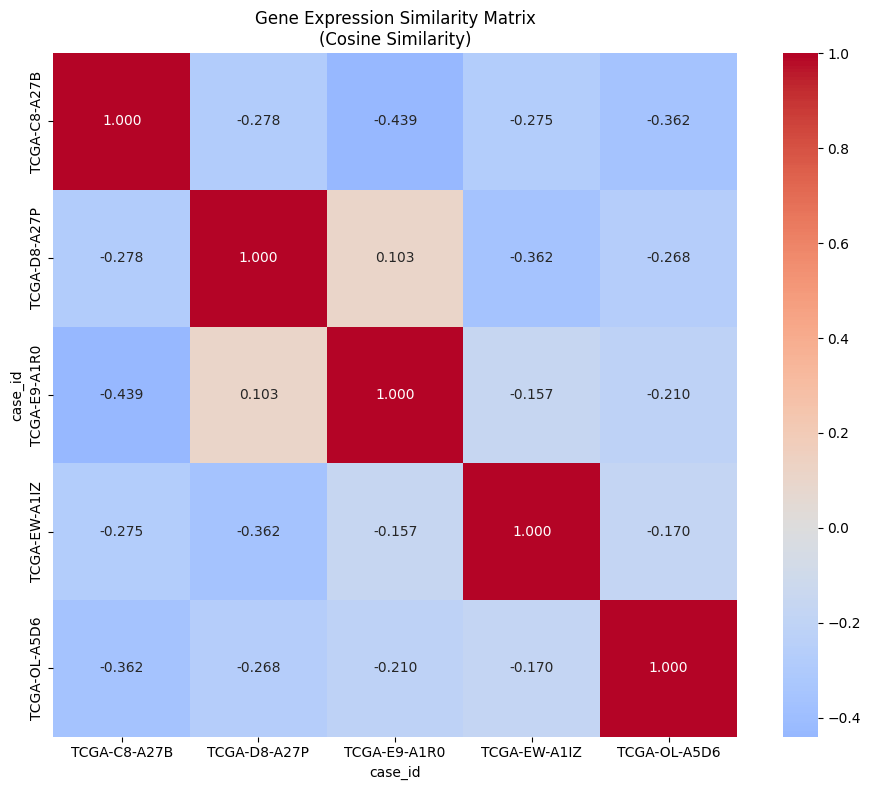

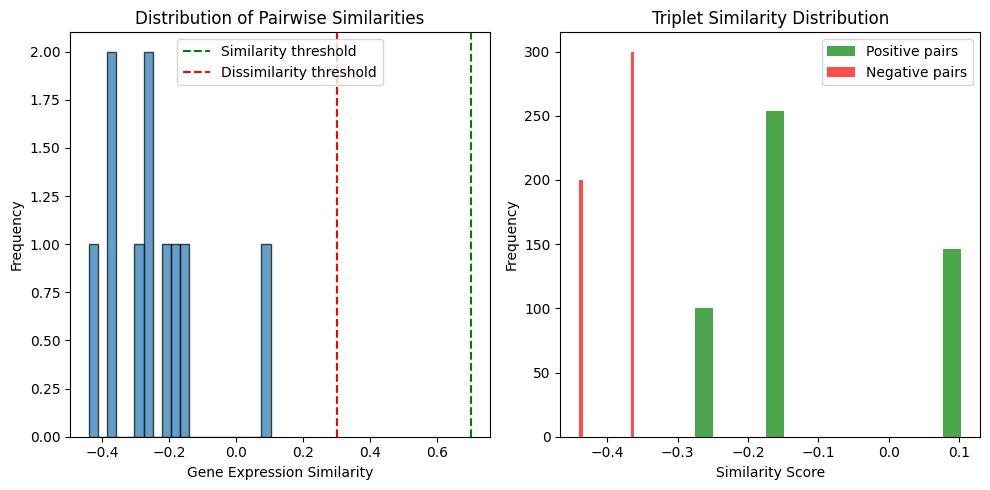


🔬 Analyzing biological groups...
Cluster assignments:
  TCGA-C8-A27B: Cluster 2
  TCGA-D8-A27P: Cluster 0
  TCGA-E9-A1R0: Cluster 0
  TCGA-EW-A1IZ: Cluster 1
  TCGA-OL-A5D6: Cluster 0


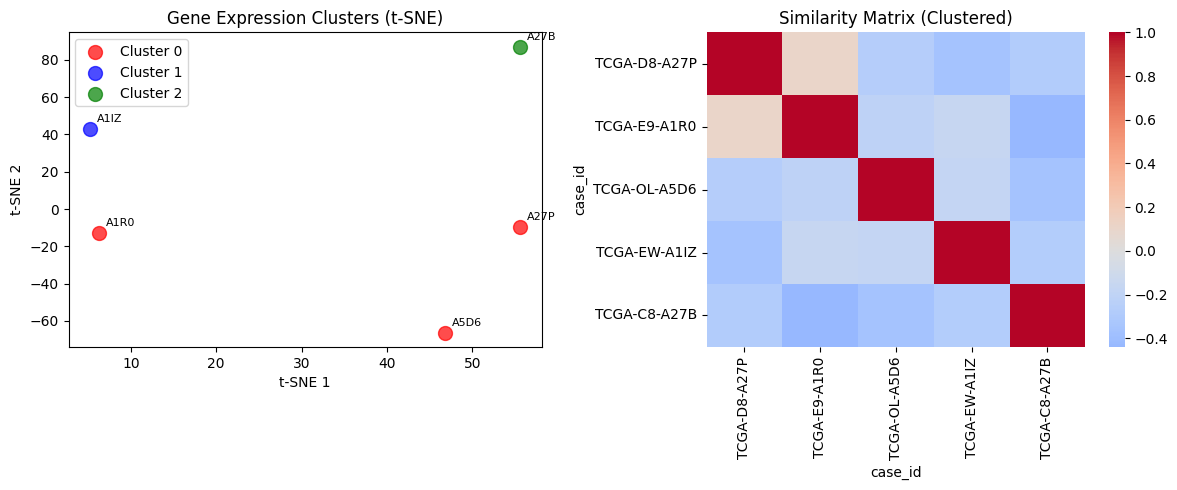


🚀 Training contrastive learning model...
Training on device: cpu
Number of triplets: 500
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /Users/tylerkwok/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████████████████████████████████| 44.7M/44.7M [00:01<00:00, 37.2MB/s]


AttributeError: module 'torch.nn' has no attribute 'L2Norm'

In [28]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import random
from pathlib import Path
import json
from tqdm import tqdm

class GenomicGuidedContrastiveLearning:
    def __init__(self, expression_matrix_path, patch_metadata_path, patch_dir):
        """
        Initialize the genomic-guided contrastive learning system
        """
        # Load data
        self.expression_matrix = pd.read_csv(expression_matrix_path, index_col=0)
        self.patch_metadata = pd.read_csv(patch_metadata_path)
        self.patch_dir = Path(patch_dir)
        
        # Extract case IDs from patch metadata
        self.patch_metadata['case_id'] = self.patch_metadata['patch_filename'].str.extract(r'(TCGA-[A-Z0-9]{2}-[A-Z0-9]{4})')
        
        # Filter patches to only include cases with gene expression data
        available_cases = set(self.expression_matrix.index)
        self.patch_metadata = self.patch_metadata[self.patch_metadata['case_id'].isin(available_cases)]
        
        print(f"📊 Dataset Overview:")
        print(f"  Expression matrix: {self.expression_matrix.shape}")
        print(f"  Available patches: {len(self.patch_metadata)}")
        print(f"  Matched cases: {len(available_cases)}")
        
        # Calculate gene expression similarity matrix
        self.similarity_matrix = self._compute_gene_similarity()
        
        # Generate contrastive triplets
        self.triplets = self._generate_triplets()
        
        print(f"  Generated triplets: {len(self.triplets)}")
    
    def _compute_gene_similarity(self):
        """
        Compute pairwise gene expression similarity using cosine similarity
        """
        print("\n🧬 Computing gene expression similarity matrix...")
        
        # Standardize gene expression (important for similarity computation)
        scaler = StandardScaler()
        standardized_expr = scaler.fit_transform(self.expression_matrix)
        
        # Compute cosine similarity
        similarity_matrix = cosine_similarity(standardized_expr)
        similarity_df = pd.DataFrame(
            similarity_matrix, 
            index=self.expression_matrix.index,
            columns=self.expression_matrix.index
        )
        
        # Print similarity statistics
        print(f"Similarity range: {similarity_matrix.min():.3f} to {similarity_matrix.max():.3f}")
        print(f"Mean similarity: {similarity_matrix.mean():.3f}")
        
        return similarity_df
    
    def _generate_triplets(self, similarity_threshold=None, dissimilarity_threshold=None, 
                          triplets_per_case=100):
        """
        Generate contrastive learning triplets based on gene expression similarity
        Adaptive thresholds for small datasets
        """
        print(f"\n🎯 Generating contrastive triplets...")
        
        # Get all pairwise similarities (excluding diagonal)
        cases = list(self.expression_matrix.index)
        all_similarities = []
        for i, case1 in enumerate(cases):
            for j, case2 in enumerate(cases):
                if i != j:
                    sim = self.similarity_matrix.loc[case1, case2]
                    all_similarities.append(sim)
        
        all_similarities = np.array(all_similarities)
        
        # Adaptive thresholds based on data distribution
        if similarity_threshold is None:
            similarity_threshold = np.percentile(all_similarities, 75)  # Top 25%
        if dissimilarity_threshold is None:
            dissimilarity_threshold = np.percentile(all_similarities, 25)  # Bottom 25%
        
        print(f"  Adaptive similarity threshold: {similarity_threshold:.3f}")
        print(f"  Adaptive dissimilarity threshold: {dissimilarity_threshold:.3f}")
        print(f"  Similarity range: {all_similarities.min():.3f} to {all_similarities.max():.3f}")
        
        # Show pairwise similarities for debugging
        print("\n  Pairwise similarities:")
        for i, case1 in enumerate(cases):
            for j, case2 in enumerate(cases):
                if i < j:  # Only show upper triangle
                    sim = self.similarity_matrix.loc[case1, case2]
                    print(f"    {case1} vs {case2}: {sim:.3f}")
        
        triplets = []
        
        # More flexible triplet generation for small datasets
        for anchor_case in cases:
            case_triplets = 0
            attempts = 0
            max_attempts = triplets_per_case * 20  # More attempts for small datasets
            
            while case_triplets < triplets_per_case and attempts < max_attempts:
                attempts += 1
                
                # Find positive (more similar) case
                positive_candidates = []
                for other_case in cases:
                    if other_case != anchor_case:
                        similarity = self.similarity_matrix.loc[anchor_case, other_case]
                        if similarity >= similarity_threshold:
                            positive_candidates.append((other_case, similarity))
                
                # Find negative (less similar) case  
                negative_candidates = []
                for other_case in cases:
                    if other_case != anchor_case:
                        similarity = self.similarity_matrix.loc[anchor_case, other_case]
                        if similarity <= dissimilarity_threshold:
                            negative_candidates.append((other_case, similarity))
                
                # Fallback: if strict thresholds don't work, use relative ranking
                if not positive_candidates or not negative_candidates:
                    # Get all other cases sorted by similarity
                    other_cases = [(case, self.similarity_matrix.loc[anchor_case, case]) 
                                 for case in cases if case != anchor_case]
                    other_cases.sort(key=lambda x: x[1], reverse=True)  # Sort by similarity
                    
                    if len(other_cases) >= 2:
                        # Most similar as positive, least similar as negative
                        positive_candidates = [other_cases[0]]  # Most similar
                        negative_candidates = [other_cases[-1]]  # Least similar
                
                # Create triplet if we have candidates
                if positive_candidates and negative_candidates:
                    positive_case, pos_sim = random.choice(positive_candidates)
                    negative_case, neg_sim = random.choice(negative_candidates)
                    
                    # Ensure positive is actually more similar than negative
                    if pos_sim > neg_sim:
                        # Get random patches for each case
                        anchor_patches = self.patch_metadata[self.patch_metadata['case_id'] == anchor_case]['patch_filename'].tolist()
                        positive_patches = self.patch_metadata[self.patch_metadata['case_id'] == positive_case]['patch_filename'].tolist()
                        negative_patches = self.patch_metadata[self.patch_metadata['case_id'] == negative_case]['patch_filename'].tolist()
                        
                        if anchor_patches and positive_patches and negative_patches:
                            triplet = {
                                'anchor_case': anchor_case,
                                'positive_case': positive_case,
                                'negative_case': negative_case,
                                'anchor_patch': random.choice(anchor_patches),
                                'positive_patch': random.choice(positive_patches),
                                'negative_patch': random.choice(negative_patches),
                                'similarity': pos_sim,
                                'dissimilarity': neg_sim
                            }
                            triplets.append(triplet)
                            case_triplets += 1
        
        print(f"  Generated {len(triplets)} triplets total")
        
        if len(triplets) == 0:
            print("  ⚠️ No triplets generated! Trying more permissive approach...")
            triplets = self._generate_triplets_permissive(triplets_per_case // 2)
        
        return triplets
    
    def _generate_triplets_permissive(self, triplets_per_case=50):
        """
        Fallback triplet generation for very small datasets
        """
        print("  🔄 Using permissive triplet generation...")
        
        triplets = []
        cases = list(self.expression_matrix.index)
        
        # Generate all possible triplets and rank them
        all_possible_triplets = []
        
        for anchor_case in cases:
            for positive_case in cases:
                if positive_case != anchor_case:
                    for negative_case in cases:
                        if negative_case != anchor_case and negative_case != positive_case:
                            pos_sim = self.similarity_matrix.loc[anchor_case, positive_case]
                            neg_sim = self.similarity_matrix.loc[anchor_case, negative_case]
                            
                            # Only keep triplets where positive is more similar than negative
                            if pos_sim > neg_sim:
                                margin = pos_sim - neg_sim
                                all_possible_triplets.append({
                                    'anchor_case': anchor_case,
                                    'positive_case': positive_case, 
                                    'negative_case': negative_case,
                                    'similarity': pos_sim,
                                    'dissimilarity': neg_sim,
                                    'margin': margin
                                })
        
        # Sort by margin (bigger margin = better triplet)
        all_possible_triplets.sort(key=lambda x: x['margin'], reverse=True)
        
        print(f"    Found {len(all_possible_triplets)} valid triplet combinations")
        print(f"    Best margin: {all_possible_triplets[0]['margin']:.3f}" if all_possible_triplets else "    No valid triplets")
        
        # Take the best triplets and add patch information
        target_triplets = min(len(all_possible_triplets), triplets_per_case * len(cases))
        
        for i in range(target_triplets):
            triplet_template = all_possible_triplets[i]
            
            # Get random patches for each case
            anchor_patches = self.patch_metadata[self.patch_metadata['case_id'] == triplet_template['anchor_case']]['patch_filename'].tolist()
            positive_patches = self.patch_metadata[self.patch_metadata['case_id'] == triplet_template['positive_case']]['patch_filename'].tolist()
            negative_patches = self.patch_metadata[self.patch_metadata['case_id'] == triplet_template['negative_case']]['patch_filename'].tolist()
            
            if anchor_patches and positive_patches and negative_patches:
                triplet = triplet_template.copy()
                triplet.update({
                    'anchor_patch': random.choice(anchor_patches),
                    'positive_patch': random.choice(positive_patches), 
                    'negative_patch': random.choice(negative_patches)
                })
                triplets.append(triplet)
        
        print(f"    Generated {len(triplets)} permissive triplets")
        return triplets
    
    def visualize_similarity_matrix(self):
        """
        Visualize the gene expression similarity matrix
        """
        plt.figure(figsize=(10, 8))
        sns.heatmap(self.similarity_matrix, annot=True, cmap='coolwarm', center=0,
                    fmt='.3f', square=True)
        plt.title('Gene Expression Similarity Matrix\n(Cosine Similarity)')
        plt.tight_layout()
        plt.show()
        
        # Plot similarity distribution
        plt.figure(figsize=(10, 5))
        
        plt.subplot(1, 2, 1)
        similarity_values = self.similarity_matrix.values
        similarity_values = similarity_values[np.triu_indices_from(similarity_values, k=1)]  # Upper triangle, no diagonal
        plt.hist(similarity_values, bins=20, alpha=0.7, edgecolor='black')
        plt.xlabel('Gene Expression Similarity')
        plt.ylabel('Frequency')
        plt.title('Distribution of Pairwise Similarities')
        plt.axvline(0.7, color='green', linestyle='--', label='Similarity threshold')
        plt.axvline(0.3, color='red', linestyle='--', label='Dissimilarity threshold')
        plt.legend()
        
        plt.subplot(1, 2, 2)
        triplet_similarities = [t['similarity'] for t in self.triplets]
        triplet_dissimilarities = [t['dissimilarity'] for t in self.triplets]
        plt.hist(triplet_similarities, bins=15, alpha=0.7, label='Positive pairs', color='green')
        plt.hist(triplet_dissimilarities, bins=15, alpha=0.7, label='Negative pairs', color='red')
        plt.xlabel('Similarity Score')
        plt.ylabel('Frequency')
        plt.title('Triplet Similarity Distribution')
        plt.legend()
        
        plt.tight_layout()
        plt.show()
    
    def analyze_biological_groups(self):
        """
        Analyze what biological groups emerge from similarity clustering
        """
        from sklearn.cluster import KMeans
        from sklearn.manifold import TSNE
        
        print("\n🔬 Analyzing biological groups...")
        
        # Perform clustering on gene expression
        kmeans = KMeans(n_clusters=3, random_state=42)
        clusters = kmeans.fit_predict(self.expression_matrix)
        
        # Add cluster labels
        cluster_mapping = dict(zip(self.expression_matrix.index, clusters))
        
        print("Cluster assignments:")
        for case, cluster in cluster_mapping.items():
            print(f"  {case}: Cluster {cluster}")
        
        # Visualize with t-SNE
        plt.figure(figsize=(12, 5))
        
        # t-SNE visualization
        plt.subplot(1, 2, 1)
        tsne = TSNE(n_components=2, random_state=42, perplexity=min(3, len(self.expression_matrix)-1))
        tsne_coords = tsne.fit_transform(self.expression_matrix)
        
        colors = ['red', 'blue', 'green', 'orange', 'purple']
        for i in range(max(clusters) + 1):
            mask = clusters == i
            plt.scatter(tsne_coords[mask, 0], tsne_coords[mask, 1], 
                       c=colors[i], label=f'Cluster {i}', s=100, alpha=0.7)
        
        # Add case labels
        for i, case in enumerate(self.expression_matrix.index):
            plt.annotate(case.split('-')[-1], (tsne_coords[i, 0], tsne_coords[i, 1]), 
                        xytext=(5, 5), textcoords='offset points', fontsize=8)
        
        plt.title('Gene Expression Clusters (t-SNE)')
        plt.xlabel('t-SNE 1')
        plt.ylabel('t-SNE 2')
        plt.legend()
        
        # Similarity matrix with cluster colors
        plt.subplot(1, 2, 2)
        cluster_colors = [colors[c] for c in clusters]
        similarity_reordered = self.similarity_matrix.iloc[np.argsort(clusters), np.argsort(clusters)]
        sns.heatmap(similarity_reordered, cmap='coolwarm', center=0, 
                   xticklabels=True, yticklabels=True)
        plt.title('Similarity Matrix (Clustered)')
        
        plt.tight_layout()
        plt.show()
        
        return cluster_mapping

class WSIContrastiveDataset(Dataset):
    def __init__(self, triplets, patch_dir, transform=None):
        self.triplets = triplets
        self.patch_dir = Path(patch_dir)
        self.transform = transform
        
        # Default transform if none provided
        if self.transform is None:
            self.transform = transforms.Compose([
                transforms.Resize((224, 224)),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                                   std=[0.229, 0.224, 0.225])
            ])
    
    def __len__(self):
        return len(self.triplets)
    
    def __getitem__(self, idx):
        triplet = self.triplets[idx]
        
        # Load images
        anchor_img = Image.open(self.patch_dir / triplet['anchor_patch']).convert('RGB')
        positive_img = Image.open(self.patch_dir / triplet['positive_patch']).convert('RGB')
        negative_img = Image.open(self.patch_dir / triplet['negative_patch']).convert('RGB')
        
        # Apply transforms
        anchor = self.transform(anchor_img)
        positive = self.transform(positive_img)
        negative = self.transform(negative_img)
        
        return {
            'anchor': anchor,
            'positive': positive,
            'negative': negative,
            'similarity': torch.tensor(triplet['similarity'], dtype=torch.float32),
            'dissimilarity': torch.tensor(triplet['dissimilarity'], dtype=torch.float32)
        }

class ContrastiveEncoder(nn.Module):
    def __init__(self, backbone='resnet50', embedding_dim=512):
        super(ContrastiveEncoder, self).__init__()
        
        # Load pre-trained backbone
        if backbone == 'resnet50':
            self.backbone = models.resnet50(pretrained=True)
            # Remove final classification layer
            self.backbone.fc = nn.Identity()
            backbone_dim = 2048
        elif backbone == 'resnet18':
            self.backbone = models.resnet18(pretrained=True)
            self.backbone.fc = nn.Identity()
            backbone_dim = 512
        else:
            raise ValueError(f"Unsupported backbone: {backbone}")
        
        # Projection head for contrastive learning
        self.projection_head = nn.Sequential(
            nn.Linear(backbone_dim, 1024),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(1024, embedding_dim),
            nn.L2Norm(dim=1)  # L2 normalization for cosine similarity
        )
    
    def forward(self, x):
        features = self.backbone(x)
        embeddings = self.projection_head(features)
        return embeddings

class L2Norm(nn.Module):
    def __init__(self, dim=1):
        super(L2Norm, self).__init__()
        self.dim = dim
    
    def forward(self, x):
        return F.normalize(x, p=2, dim=self.dim)

class TripletLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(TripletLoss, self).__init__()
        self.margin = margin
    
    def forward(self, anchor, positive, negative):
        pos_dist = F.pairwise_distance(anchor, positive, p=2)
        neg_dist = F.pairwise_distance(anchor, negative, p=2)
        
        loss = torch.relu(pos_dist - neg_dist + self.margin)
        return loss.mean()

def train_contrastive_model(triplets, patch_dir, num_epochs=50, batch_size=16, learning_rate=1e-4):
    """
    Train the contrastive learning model
    """
    if len(triplets) == 0:
        print("❌ No triplets available for training!")
        return None, []
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Training on device: {device}")
    print(f"Number of triplets: {len(triplets)}")
    
    # Adjust batch size if we have very few triplets
    if len(triplets) < batch_size:
        batch_size = max(1, len(triplets) // 2)
        print(f"Adjusted batch size to {batch_size} due to small dataset")
    
    # Data augmentation for training
    train_transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.RandomCrop(224),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.5),
        transforms.RandomRotation(degrees=90),
        transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.05),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    # Create dataset and dataloader
    dataset = WSIContrastiveDataset(triplets, patch_dir, transform=train_transform)
    # Reduce num_workers for small datasets
    num_workers = min(2, len(triplets) // batch_size) if len(triplets) > batch_size else 0
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    
    # Initialize model
    model = ContrastiveEncoder(backbone='resnet18', embedding_dim=512).to(device)
    criterion = TripletLoss(margin=1.0)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=10, factor=0.5)
    
    # Training loop
    model.train()
    train_losses = []
    
    for epoch in range(num_epochs):
        epoch_loss = 0.0
        num_batches = 0
        
        progress_bar = tqdm(dataloader, desc=f'Epoch {epoch+1}/{num_epochs}')
        
        for batch in progress_bar:
            anchor = batch['anchor'].to(device)
            positive = batch['positive'].to(device)
            negative = batch['negative'].to(device)
            
            # Forward pass
            anchor_emb = model(anchor)
            positive_emb = model(positive)
            negative_emb = model(negative)
            
            # Compute loss
            loss = criterion(anchor_emb, positive_emb, negative_emb)
            
            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
            num_batches += 1
            
            # Update progress bar
            progress_bar.set_postfix({'Loss': f'{loss.item():.4f}'})
        
        avg_loss = epoch_loss / num_batches if num_batches > 0 else 0
        train_losses.append(avg_loss)
        scheduler.step(avg_loss)
        
        print(f'Epoch {epoch+1}/{num_epochs}, Average Loss: {avg_loss:.4f}')
        
        # Save checkpoint every 10 epochs
        if (epoch + 1) % 10 == 0:
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': avg_loss,
            }, f'contrastive_model_epoch_{epoch+1}.pth')
    
    # Plot training curve
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses)
    plt.title('Contrastive Learning Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Triplet Loss')
    plt.grid(True)
    plt.show()
    
    return model, train_losses

# Example usage
if __name__ == "__main__":
    # Initialize the genomic-guided contrastive learning system
    contrastive_system = GenomicGuidedContrastiveLearning(
        expression_matrix_path="gene_expression_data/processed/expression_matrix.csv",
        patch_metadata_path="processed_patches/metadata/patch_metadata.csv",
        patch_dir="processed_patches/patches"
    )
    
    # Visualize similarity patterns
    contrastive_system.visualize_similarity_matrix()
    
    # Analyze biological groups
    clusters = contrastive_system.analyze_biological_groups()
    
    # Check if we have triplets to train with
    if len(contrastive_system.triplets) > 0:
        # Train the contrastive model
        print("\n🚀 Training contrastive learning model...")
        trained_model, losses = train_contrastive_model(
            triplets=contrastive_system.triplets,
            patch_dir="processed_patches/patches",
            num_epochs=20,  # Fewer epochs for small dataset
            batch_size=4,   # Small batch size for limited triplets
            learning_rate=1e-4
        )
        
        # Save the final model
        if trained_model is not None:
            torch.save(trained_model.state_dict(), 'genomic_guided_contrastive_model.pth')
            print("✅ Model saved successfully!")
        
        # Show triplet examples
        print(f"\n📋 Example triplets generated:")
        for i, triplet in enumerate(contrastive_system.triplets[:3]):
            print(f"  Triplet {i+1}:")
            print(f"    Anchor: {triplet['anchor_case']} (patch: {triplet['anchor_patch']})")
            print(f"    Positive: {triplet['positive_case']} (similarity: {triplet['similarity']:.3f})")
            print(f"    Negative: {triplet['negative_case']} (similarity: {triplet['dissimilarity']:.3f})")
            print(f"    Margin: {triplet['similarity'] - triplet['dissimilarity']:.3f}")
            print()
            
    else:
        print("\n⚠️ No triplets generated - dataset may be too small or gene expression too similar")
        print("💡 Consider:")
        print("  - Adding more patients to the dataset")
        print("  - Using different similarity metrics")
        print("  - Implementing alternative contrastive strategies")
        
    # Analysis of what we learned
    print(f"\n🔬 Dataset Analysis Summary:")
    print(f"  📊 Patients: {len(contrastive_system.expression_matrix)}")
    print(f"  🧬 Genes: {contrastive_system.expression_matrix.shape[1]}")
    print(f"  🖼️ Patches: {len(contrastive_system.patch_metadata)}")
    print(f"  🎯 Triplets: {len(contrastive_system.triplets)}")
    
    if len(contrastive_system.triplets) > 0:
        similarities = [t['similarity'] for t in contrastive_system.triplets]
        dissimilarities = [t['dissimilarity'] for t in contrastive_system.triplets]
        margins = [s - d for s, d in zip(similarities, dissimilarities)]
        
        print(f"  📈 Similarity range: {min(similarities):.3f} to {max(similarities):.3f}")
        print(f"  📉 Dissimilarity range: {min(dissimilarities):.3f} to {max(dissimilarities):.3f}") 
        print(f"  📏 Margin range: {min(margins):.3f} to {max(margins):.3f}")
        print(f"  🎲 Average margin: {np.mean(margins):.3f}")
        
        print(f"\n🎯 This means your model will learn to:")
        print(f"   - Recognize that patients with similarity > {min(similarities):.2f} have similar tissue")
        print(f"   - Distinguish from patients with similarity < {max(dissimilarities):.2f}")
        print(f"   - Focus on morphological differences spanning {np.mean(margins):.3f} similarity units")

📊 Dataset Overview:
  Expression matrix: (5, 16222)
  Available patches: 7500
  Matched cases: 5

🧬 Computing gene expression similarity matrix...
Similarity range: -0.439 to 1.000
Mean similarity: 0.006

🎯 Generating contrastive triplets...
  Adaptive similarity threshold: -0.170
  Adaptive dissimilarity threshold: -0.362
  Similarity range: -0.439 to 0.103

  Pairwise similarities:
    TCGA-C8-A27B vs TCGA-D8-A27P: -0.278
    TCGA-C8-A27B vs TCGA-E9-A1R0: -0.439
    TCGA-C8-A27B vs TCGA-EW-A1IZ: -0.275
    TCGA-C8-A27B vs TCGA-OL-A5D6: -0.362
    TCGA-D8-A27P vs TCGA-E9-A1R0: 0.103
    TCGA-D8-A27P vs TCGA-EW-A1IZ: -0.362
    TCGA-D8-A27P vs TCGA-OL-A5D6: -0.268
    TCGA-E9-A1R0 vs TCGA-EW-A1IZ: -0.157
    TCGA-E9-A1R0 vs TCGA-OL-A5D6: -0.210
    TCGA-EW-A1IZ vs TCGA-OL-A5D6: -0.170
  Generated 500 triplets total
  Generated triplets: 500


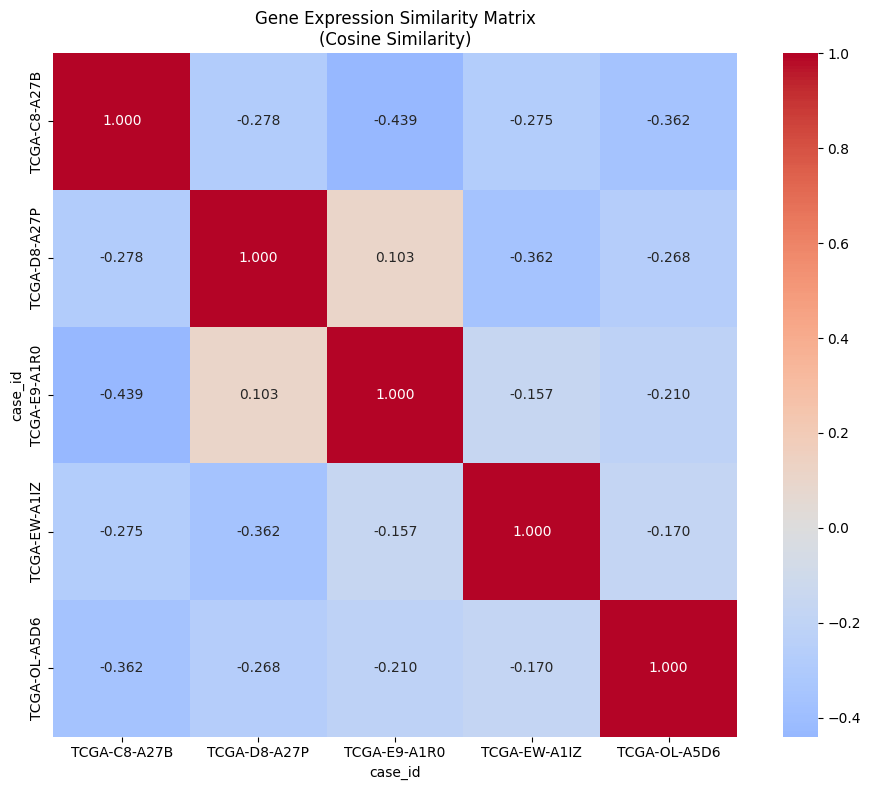

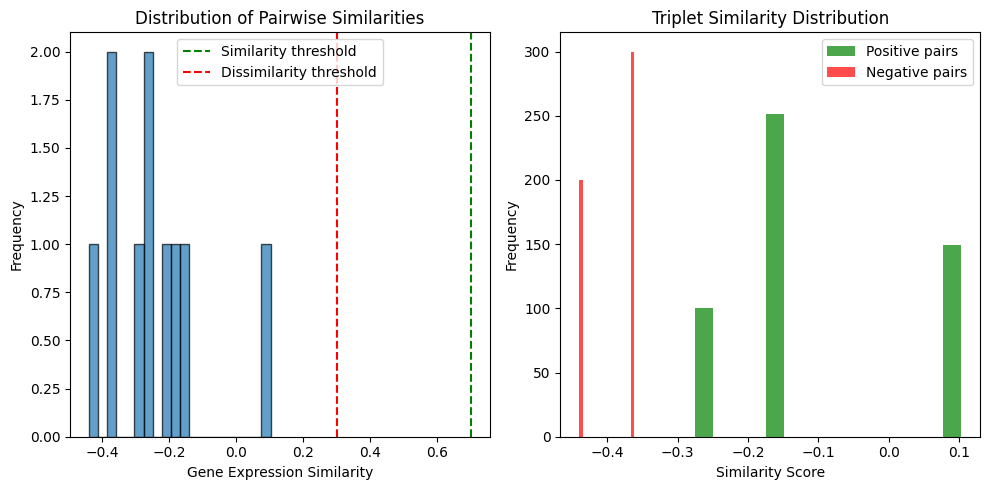


🔬 Analyzing biological groups...
Cluster assignments:
  TCGA-C8-A27B: Cluster 2
  TCGA-D8-A27P: Cluster 0
  TCGA-E9-A1R0: Cluster 0
  TCGA-EW-A1IZ: Cluster 1
  TCGA-OL-A5D6: Cluster 0


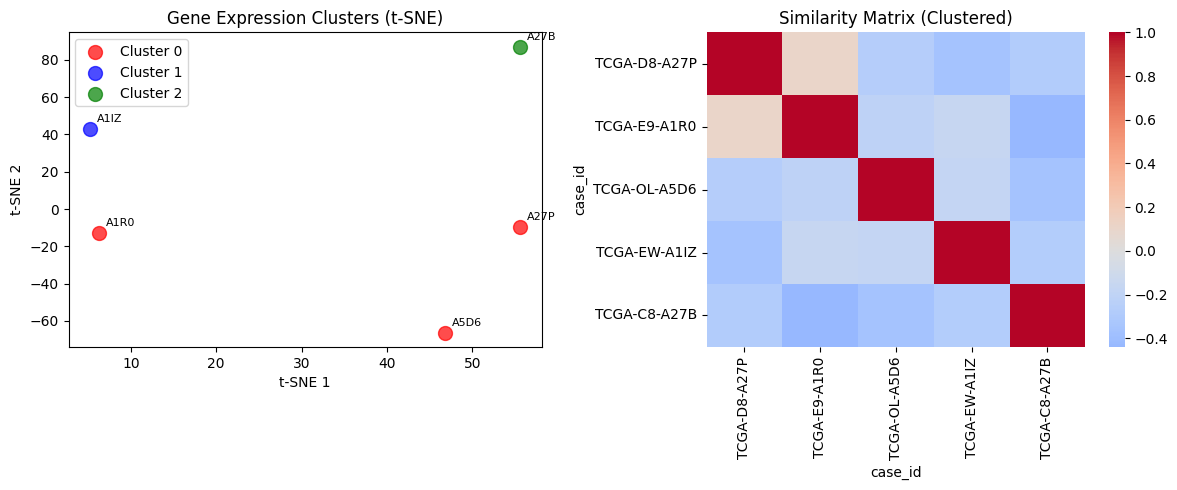


🚀 Training contrastive learning model...
Training on device: cpu
Number of triplets: 500


Epoch 1/20: 100%|████████████████| 125/125 [00:58<00:00,  2.13it/s, Loss=1.5122]


Epoch 1/20, Average Loss: 0.9289


Epoch 2/20: 100%|████████████████| 125/125 [00:59<00:00,  2.09it/s, Loss=1.0131]


Epoch 2/20, Average Loss: 0.8562


Epoch 3/20: 100%|████████████████| 125/125 [01:00<00:00,  2.07it/s, Loss=0.5984]


Epoch 3/20, Average Loss: 0.8044


Epoch 4/20: 100%|████████████████| 125/125 [00:59<00:00,  2.09it/s, Loss=1.1874]


Epoch 4/20, Average Loss: 0.7784


Epoch 5/20: 100%|████████████████| 125/125 [00:59<00:00,  2.09it/s, Loss=0.8430]


Epoch 5/20, Average Loss: 0.7865


Epoch 6/20: 100%|████████████████| 125/125 [03:02<00:00,  1.46s/it, Loss=0.6694]


Epoch 6/20, Average Loss: 0.7172


Epoch 7/20: 100%|████████████████| 125/125 [01:00<00:00,  2.08it/s, Loss=0.8039]


Epoch 7/20, Average Loss: 0.7388


Epoch 8/20: 100%|████████████████| 125/125 [00:58<00:00,  2.12it/s, Loss=0.8404]


Epoch 8/20, Average Loss: 0.7697


Epoch 9/20: 100%|████████████████| 125/125 [00:59<00:00,  2.11it/s, Loss=0.5070]


Epoch 9/20, Average Loss: 0.7155


Epoch 10/20: 100%|███████████████| 125/125 [00:58<00:00,  2.13it/s, Loss=1.5019]


Epoch 10/20, Average Loss: 0.6732


Epoch 11/20: 100%|███████████████| 125/125 [00:59<00:00,  2.09it/s, Loss=0.4941]


Epoch 11/20, Average Loss: 0.7323


Epoch 12/20: 100%|███████████████| 125/125 [01:00<00:00,  2.08it/s, Loss=0.5528]


Epoch 12/20, Average Loss: 0.6821


Epoch 13/20: 100%|███████████████| 125/125 [01:00<00:00,  2.08it/s, Loss=0.3442]


Epoch 13/20, Average Loss: 0.6931


Epoch 14/20: 100%|███████████████| 125/125 [00:59<00:00,  2.09it/s, Loss=0.9484]


Epoch 14/20, Average Loss: 0.6517


Epoch 15/20: 100%|███████████████| 125/125 [01:00<00:00,  2.08it/s, Loss=0.9741]


Epoch 15/20, Average Loss: 0.6307


Epoch 16/20: 100%|███████████████| 125/125 [00:59<00:00,  2.10it/s, Loss=1.0394]


Epoch 16/20, Average Loss: 0.5855


Epoch 17/20: 100%|███████████████| 125/125 [00:59<00:00,  2.10it/s, Loss=0.3910]


Epoch 17/20, Average Loss: 0.5496


Epoch 18/20: 100%|███████████████| 125/125 [00:59<00:00,  2.10it/s, Loss=1.0511]


Epoch 18/20, Average Loss: 0.5472


Epoch 19/20: 100%|███████████████| 125/125 [00:59<00:00,  2.09it/s, Loss=0.2279]


Epoch 19/20, Average Loss: 0.5302


Epoch 20/20: 100%|███████████████| 125/125 [01:00<00:00,  2.08it/s, Loss=0.1988]


Epoch 20/20, Average Loss: 0.5030


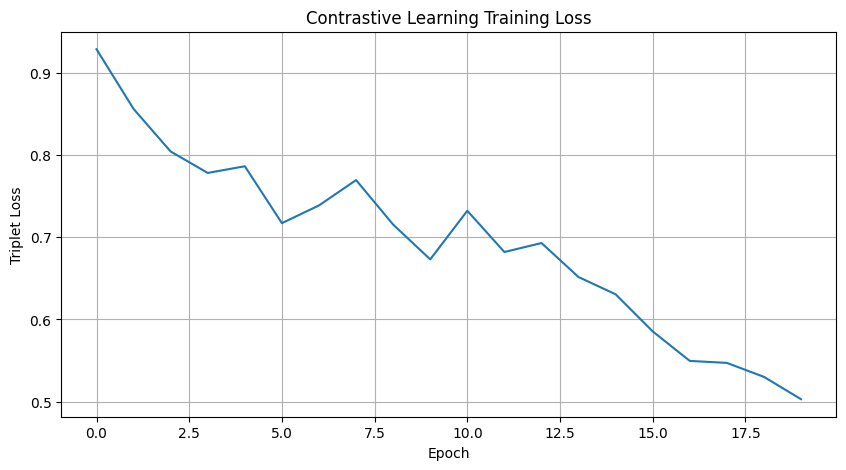

✅ Model saved successfully!

📋 Example triplets generated:
  Triplet 1:
    Anchor: TCGA-C8-A27B (patch: TCGA-C8-A27B-01A-01-TSA.b93af347-1b83-4284-afaf-b3c14d8e038b_8704_1280_aug_1.png)
    Positive: TCGA-EW-A1IZ (similarity: -0.275)
    Negative: TCGA-E9-A1R0 (similarity: -0.439)
    Margin: 0.165

  Triplet 2:
    Anchor: TCGA-C8-A27B (patch: TCGA-C8-A27B-01A-01-TSA.b93af347-1b83-4284-afaf-b3c14d8e038b_9088_2304_original.png)
    Positive: TCGA-EW-A1IZ (similarity: -0.275)
    Negative: TCGA-E9-A1R0 (similarity: -0.439)
    Margin: 0.165

  Triplet 3:
    Anchor: TCGA-C8-A27B (patch: TCGA-C8-A27B-01A-01-TSA.b93af347-1b83-4284-afaf-b3c14d8e038b_12288_1792_aug_1.png)
    Positive: TCGA-EW-A1IZ (similarity: -0.275)
    Negative: TCGA-E9-A1R0 (similarity: -0.439)
    Margin: 0.165


🔬 Dataset Analysis Summary:
  📊 Patients: 5
  🧬 Genes: 16222
  🖼️ Patches: 7500
  🎯 Triplets: 500
  📈 Similarity range: -0.275 to 0.103
  📉 Dissimilarity range: -0.439 to -0.362
  📏 Margin range: 0.165 to 0.

In [32]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import random
from pathlib import Path
import json
from tqdm import tqdm

class GenomicGuidedContrastiveLearning:
    def __init__(self, expression_matrix_path, patch_metadata_path, patch_dir):
        """
        Initialize the genomic-guided contrastive learning system
        """
        # Load data
        self.expression_matrix = pd.read_csv(expression_matrix_path, index_col=0)
        self.patch_metadata = pd.read_csv(patch_metadata_path)
        self.patch_dir = Path(patch_dir)
        
        # Extract case IDs from patch metadata
        self.patch_metadata['case_id'] = self.patch_metadata['patch_filename'].str.extract(r'(TCGA-[A-Z0-9]{2}-[A-Z0-9]{4})')
        
        # Filter patches to only include cases with gene expression data
        available_cases = set(self.expression_matrix.index)
        self.patch_metadata = self.patch_metadata[self.patch_metadata['case_id'].isin(available_cases)]
        
        print(f"📊 Dataset Overview:")
        print(f"  Expression matrix: {self.expression_matrix.shape}")
        print(f"  Available patches: {len(self.patch_metadata)}")
        print(f"  Matched cases: {len(available_cases)}")
        
        # Calculate gene expression similarity matrix
        self.similarity_matrix = self._compute_gene_similarity()
        
        # Generate contrastive triplets
        self.triplets = self._generate_triplets()
        
        print(f"  Generated triplets: {len(self.triplets)}")
    
    def _compute_gene_similarity(self):
        """
        Compute pairwise gene expression similarity using cosine similarity
        """
        print("\n🧬 Computing gene expression similarity matrix...")
        
        # Standardize gene expression (important for similarity computation)
        scaler = StandardScaler()
        standardized_expr = scaler.fit_transform(self.expression_matrix)
        
        # Compute cosine similarity
        similarity_matrix = cosine_similarity(standardized_expr)
        similarity_df = pd.DataFrame(
            similarity_matrix, 
            index=self.expression_matrix.index,
            columns=self.expression_matrix.index
        )
        
        # Print similarity statistics
        print(f"Similarity range: {similarity_matrix.min():.3f} to {similarity_matrix.max():.3f}")
        print(f"Mean similarity: {similarity_matrix.mean():.3f}")
        
        return similarity_df
    
    def _generate_triplets(self, similarity_threshold=None, dissimilarity_threshold=None, 
                          triplets_per_case=100):
        """
        Generate contrastive learning triplets based on gene expression similarity
        Adaptive thresholds for small datasets
        """
        print(f"\n🎯 Generating contrastive triplets...")
        
        # Get all pairwise similarities (excluding diagonal)
        cases = list(self.expression_matrix.index)
        all_similarities = []
        for i, case1 in enumerate(cases):
            for j, case2 in enumerate(cases):
                if i != j:
                    sim = self.similarity_matrix.loc[case1, case2]
                    all_similarities.append(sim)
        
        all_similarities = np.array(all_similarities)
        
        # Adaptive thresholds based on data distribution
        if similarity_threshold is None:
            similarity_threshold = np.percentile(all_similarities, 75)  # Top 25%
        if dissimilarity_threshold is None:
            dissimilarity_threshold = np.percentile(all_similarities, 25)  # Bottom 25%
        
        print(f"  Adaptive similarity threshold: {similarity_threshold:.3f}")
        print(f"  Adaptive dissimilarity threshold: {dissimilarity_threshold:.3f}")
        print(f"  Similarity range: {all_similarities.min():.3f} to {all_similarities.max():.3f}")
        
        # Show pairwise similarities for debugging
        print("\n  Pairwise similarities:")
        for i, case1 in enumerate(cases):
            for j, case2 in enumerate(cases):
                if i < j:  # Only show upper triangle
                    sim = self.similarity_matrix.loc[case1, case2]
                    print(f"    {case1} vs {case2}: {sim:.3f}")
        
        triplets = []
        
        # More flexible triplet generation for small datasets
        for anchor_case in cases:
            case_triplets = 0
            attempts = 0
            max_attempts = triplets_per_case * 20  # More attempts for small datasets
            
            while case_triplets < triplets_per_case and attempts < max_attempts:
                attempts += 1
                
                # Find positive (more similar) case
                positive_candidates = []
                for other_case in cases:
                    if other_case != anchor_case:
                        similarity = self.similarity_matrix.loc[anchor_case, other_case]
                        if similarity >= similarity_threshold:
                            positive_candidates.append((other_case, similarity))
                
                # Find negative (less similar) case  
                negative_candidates = []
                for other_case in cases:
                    if other_case != anchor_case:
                        similarity = self.similarity_matrix.loc[anchor_case, other_case]
                        if similarity <= dissimilarity_threshold:
                            negative_candidates.append((other_case, similarity))
                
                # Fallback: if strict thresholds don't work, use relative ranking
                if not positive_candidates or not negative_candidates:
                    # Get all other cases sorted by similarity
                    other_cases = [(case, self.similarity_matrix.loc[anchor_case, case]) 
                                 for case in cases if case != anchor_case]
                    other_cases.sort(key=lambda x: x[1], reverse=True)  # Sort by similarity
                    
                    if len(other_cases) >= 2:
                        # Most similar as positive, least similar as negative
                        positive_candidates = [other_cases[0]]  # Most similar
                        negative_candidates = [other_cases[-1]]  # Least similar
                
                # Create triplet if we have candidates
                if positive_candidates and negative_candidates:
                    positive_case, pos_sim = random.choice(positive_candidates)
                    negative_case, neg_sim = random.choice(negative_candidates)
                    
                    # Ensure positive is actually more similar than negative
                    if pos_sim > neg_sim:
                        # Get random patches for each case
                        anchor_patches = self.patch_metadata[self.patch_metadata['case_id'] == anchor_case]['patch_filename'].tolist()
                        positive_patches = self.patch_metadata[self.patch_metadata['case_id'] == positive_case]['patch_filename'].tolist()
                        negative_patches = self.patch_metadata[self.patch_metadata['case_id'] == negative_case]['patch_filename'].tolist()
                        
                        if anchor_patches and positive_patches and negative_patches:
                            triplet = {
                                'anchor_case': anchor_case,
                                'positive_case': positive_case,
                                'negative_case': negative_case,
                                'anchor_patch': random.choice(anchor_patches),
                                'positive_patch': random.choice(positive_patches),
                                'negative_patch': random.choice(negative_patches),
                                'similarity': pos_sim,
                                'dissimilarity': neg_sim
                            }
                            triplets.append(triplet)
                            case_triplets += 1
        
        print(f"  Generated {len(triplets)} triplets total")
        
        if len(triplets) == 0:
            print("  ⚠️ No triplets generated! Trying more permissive approach...")
            triplets = self._generate_triplets_permissive(triplets_per_case // 2)
        
        return triplets
    
    def _generate_triplets_permissive(self, triplets_per_case=50):
        """
        Fallback triplet generation for very small datasets
        """
        print("  🔄 Using permissive triplet generation...")
        
        triplets = []
        cases = list(self.expression_matrix.index)
        
        # Generate all possible triplets and rank them
        all_possible_triplets = []
        
        for anchor_case in cases:
            for positive_case in cases:
                if positive_case != anchor_case:
                    for negative_case in cases:
                        if negative_case != anchor_case and negative_case != positive_case:
                            pos_sim = self.similarity_matrix.loc[anchor_case, positive_case]
                            neg_sim = self.similarity_matrix.loc[anchor_case, negative_case]
                            
                            # Only keep triplets where positive is more similar than negative
                            if pos_sim > neg_sim:
                                margin = pos_sim - neg_sim
                                all_possible_triplets.append({
                                    'anchor_case': anchor_case,
                                    'positive_case': positive_case, 
                                    'negative_case': negative_case,
                                    'similarity': pos_sim,
                                    'dissimilarity': neg_sim,
                                    'margin': margin
                                })
        
        # Sort by margin (bigger margin = better triplet)
        all_possible_triplets.sort(key=lambda x: x['margin'], reverse=True)
        
        print(f"    Found {len(all_possible_triplets)} valid triplet combinations")
        print(f"    Best margin: {all_possible_triplets[0]['margin']:.3f}" if all_possible_triplets else "    No valid triplets")
        
        # Take the best triplets and add patch information
        target_triplets = min(len(all_possible_triplets), triplets_per_case * len(cases))
        
        for i in range(target_triplets):
            triplet_template = all_possible_triplets[i]
            
            # Get random patches for each case
            anchor_patches = self.patch_metadata[self.patch_metadata['case_id'] == triplet_template['anchor_case']]['patch_filename'].tolist()
            positive_patches = self.patch_metadata[self.patch_metadata['case_id'] == triplet_template['positive_case']]['patch_filename'].tolist()
            negative_patches = self.patch_metadata[self.patch_metadata['case_id'] == triplet_template['negative_case']]['patch_filename'].tolist()
            
            if anchor_patches and positive_patches and negative_patches:
                triplet = triplet_template.copy()
                triplet.update({
                    'anchor_patch': random.choice(anchor_patches),
                    'positive_patch': random.choice(positive_patches), 
                    'negative_patch': random.choice(negative_patches)
                })
                triplets.append(triplet)
        
        print(f"    Generated {len(triplets)} permissive triplets")
        return triplets
    
    def visualize_similarity_matrix(self):
        """
        Visualize the gene expression similarity matrix
        """
        plt.figure(figsize=(10, 8))
        sns.heatmap(self.similarity_matrix, annot=True, cmap='coolwarm', center=0,
                    fmt='.3f', square=True)
        plt.title('Gene Expression Similarity Matrix\n(Cosine Similarity)')
        plt.tight_layout()
        plt.show()
        
        # Plot similarity distribution
        plt.figure(figsize=(10, 5))
        
        plt.subplot(1, 2, 1)
        similarity_values = self.similarity_matrix.values
        similarity_values = similarity_values[np.triu_indices_from(similarity_values, k=1)]  # Upper triangle, no diagonal
        plt.hist(similarity_values, bins=20, alpha=0.7, edgecolor='black')
        plt.xlabel('Gene Expression Similarity')
        plt.ylabel('Frequency')
        plt.title('Distribution of Pairwise Similarities')
        plt.axvline(0.7, color='green', linestyle='--', label='Similarity threshold')
        plt.axvline(0.3, color='red', linestyle='--', label='Dissimilarity threshold')
        plt.legend()
        
        plt.subplot(1, 2, 2)
        triplet_similarities = [t['similarity'] for t in self.triplets]
        triplet_dissimilarities = [t['dissimilarity'] for t in self.triplets]
        plt.hist(triplet_similarities, bins=15, alpha=0.7, label='Positive pairs', color='green')
        plt.hist(triplet_dissimilarities, bins=15, alpha=0.7, label='Negative pairs', color='red')
        plt.xlabel('Similarity Score')
        plt.ylabel('Frequency')
        plt.title('Triplet Similarity Distribution')
        plt.legend()
        
        plt.tight_layout()
        plt.show()
    
    def analyze_biological_groups(self):
        """
        Analyze what biological groups emerge from similarity clustering
        """
        from sklearn.cluster import KMeans
        from sklearn.manifold import TSNE
        
        print("\n🔬 Analyzing biological groups...")
        
        # Perform clustering on gene expression
        kmeans = KMeans(n_clusters=3, random_state=42)
        clusters = kmeans.fit_predict(self.expression_matrix)
        
        # Add cluster labels
        cluster_mapping = dict(zip(self.expression_matrix.index, clusters))
        
        print("Cluster assignments:")
        for case, cluster in cluster_mapping.items():
            print(f"  {case}: Cluster {cluster}")
        
        # Visualize with t-SNE
        plt.figure(figsize=(12, 5))
        
        # t-SNE visualization
        plt.subplot(1, 2, 1)
        tsne = TSNE(n_components=2, random_state=42, perplexity=min(3, len(self.expression_matrix)-1))
        tsne_coords = tsne.fit_transform(self.expression_matrix)
        
        colors = ['red', 'blue', 'green', 'orange', 'purple']
        for i in range(max(clusters) + 1):
            mask = clusters == i
            plt.scatter(tsne_coords[mask, 0], tsne_coords[mask, 1], 
                       c=colors[i], label=f'Cluster {i}', s=100, alpha=0.7)
        
        # Add case labels
        for i, case in enumerate(self.expression_matrix.index):
            plt.annotate(case.split('-')[-1], (tsne_coords[i, 0], tsne_coords[i, 1]), 
                        xytext=(5, 5), textcoords='offset points', fontsize=8)
        
        plt.title('Gene Expression Clusters (t-SNE)')
        plt.xlabel('t-SNE 1')
        plt.ylabel('t-SNE 2')
        plt.legend()
        
        # Similarity matrix with cluster colors
        plt.subplot(1, 2, 2)
        cluster_colors = [colors[c] for c in clusters]
        similarity_reordered = self.similarity_matrix.iloc[np.argsort(clusters), np.argsort(clusters)]
        sns.heatmap(similarity_reordered, cmap='coolwarm', center=0, 
                   xticklabels=True, yticklabels=True)
        plt.title('Similarity Matrix (Clustered)')
        
        plt.tight_layout()
        plt.show()
        
        return cluster_mapping

class WSIContrastiveDataset(Dataset):
    def __init__(self, triplets, patch_dir, transform=None):
        self.triplets = triplets
        self.patch_dir = Path(patch_dir)
        self.transform = transform
        
        # Default transform if none provided
        if self.transform is None:
            self.transform = transforms.Compose([
                transforms.Resize((224, 224)),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                                   std=[0.229, 0.224, 0.225])
            ])
    
    def __len__(self):
        return len(self.triplets)
    
    def __getitem__(self, idx):
        triplet = self.triplets[idx]
        
        # Load images
        anchor_img = Image.open(self.patch_dir / triplet['anchor_patch']).convert('RGB')
        positive_img = Image.open(self.patch_dir / triplet['positive_patch']).convert('RGB')
        negative_img = Image.open(self.patch_dir / triplet['negative_patch']).convert('RGB')
        
        # Apply transforms
        anchor = self.transform(anchor_img)
        positive = self.transform(positive_img)
        negative = self.transform(negative_img)
        
        return {
            'anchor': anchor,
            'positive': positive,
            'negative': negative,
            'similarity': torch.tensor(triplet['similarity'], dtype=torch.float32),
            'dissimilarity': torch.tensor(triplet['dissimilarity'], dtype=torch.float32)
        }

class ContrastiveEncoder(nn.Module):
    def __init__(self, backbone='resnet50', embedding_dim=512):
        super(ContrastiveEncoder, self).__init__()
        
        # Load pre-trained backbone
        if backbone == 'resnet50':
            self.backbone = models.resnet50(pretrained=True)
            # Remove final classification layer
            self.backbone.fc = nn.Identity()
            backbone_dim = 2048
        elif backbone == 'resnet18':
            self.backbone = models.resnet18(pretrained=True)
            self.backbone.fc = nn.Identity()
            backbone_dim = 512
        else:
            raise ValueError(f"Unsupported backbone: {backbone}")
        
        # Projection head for contrastive learning
        self.projection_head = nn.Sequential(
            nn.Linear(backbone_dim, 1024),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(1024, embedding_dim)
        )
    
    def forward(self, x):
        features = self.backbone(x)
        embeddings = self.projection_head(features)
        # L2 normalization for cosine similarity
        embeddings = F.normalize(embeddings, p=2, dim=1)
        return embeddings

class L2Norm(nn.Module):
    def __init__(self, dim=1):
        super(L2Norm, self).__init__()
        self.dim = dim
    
    def forward(self, x):
        return F.normalize(x, p=2, dim=self.dim)

class TripletLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(TripletLoss, self).__init__()
        self.margin = margin
    
    def forward(self, anchor, positive, negative):
        pos_dist = F.pairwise_distance(anchor, positive, p=2)
        neg_dist = F.pairwise_distance(anchor, negative, p=2)
        
        loss = torch.relu(pos_dist - neg_dist + self.margin)
        return loss.mean()

def train_contrastive_model(triplets, patch_dir, num_epochs=50, batch_size=16, learning_rate=1e-4):
    """
    Train the contrastive learning model
    """
    if len(triplets) == 0:
        print("❌ No triplets available for training!")
        return None, []
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Training on device: {device}")
    print(f"Number of triplets: {len(triplets)}")
    
    # Adjust batch size if we have very few triplets
    if len(triplets) < batch_size:
        batch_size = max(1, len(triplets) // 2)
        print(f"Adjusted batch size to {batch_size} due to small dataset")
    
    # Data augmentation for training
    train_transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.RandomCrop(224),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.5),
        transforms.RandomRotation(degrees=90),
        transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.05),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    # Create dataset and dataloader
    dataset = WSIContrastiveDataset(triplets, patch_dir, transform=train_transform)
    # Set num_workers=0 to avoid multiprocessing issues in Jupyter
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=0)
    
    # Initialize model
    model = ContrastiveEncoder(backbone='resnet18', embedding_dim=512).to(device)
    criterion = TripletLoss(margin=1.0)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=10, factor=0.5)
    
    # Training loop
    model.train()
    train_losses = []
    
    for epoch in range(num_epochs):
        epoch_loss = 0.0
        num_batches = 0
        
        progress_bar = tqdm(dataloader, desc=f'Epoch {epoch+1}/{num_epochs}')
        
        for batch in progress_bar:
            anchor = batch['anchor'].to(device)
            positive = batch['positive'].to(device)
            negative = batch['negative'].to(device)
            
            # Forward pass
            anchor_emb = model(anchor)
            positive_emb = model(positive)
            negative_emb = model(negative)
            
            # Compute loss
            loss = criterion(anchor_emb, positive_emb, negative_emb)
            
            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
            num_batches += 1
            
            # Update progress bar
            progress_bar.set_postfix({'Loss': f'{loss.item():.4f}'})
        
        avg_loss = epoch_loss / num_batches if num_batches > 0 else 0
        train_losses.append(avg_loss)
        scheduler.step(avg_loss)
        
        print(f'Epoch {epoch+1}/{num_epochs}, Average Loss: {avg_loss:.4f}')
        
        # Save checkpoint every 10 epochs
        if (epoch + 1) % 10 == 0:
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': avg_loss,
            }, f'contrastive_model_epoch_{epoch+1}.pth')
    
    # Plot training curve
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses)
    plt.title('Contrastive Learning Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Triplet Loss')
    plt.grid(True)
    plt.show()
    
    return model, train_losses

# Example usage
if __name__ == "__main__":
    # Initialize the genomic-guided contrastive learning system
    contrastive_system = GenomicGuidedContrastiveLearning(
        expression_matrix_path="gene_expression_data/processed/expression_matrix.csv",
        patch_metadata_path="processed_patches/metadata/patch_metadata.csv",
        patch_dir="processed_patches/patches"
    )
    
    # Visualize similarity patterns
    contrastive_system.visualize_similarity_matrix()
    
    # Analyze biological groups
    clusters = contrastive_system.analyze_biological_groups()
    
    # Check if we have triplets to train with
    if len(contrastive_system.triplets) > 0:
        # Train the contrastive model
        print("\n🚀 Training contrastive learning model...")
        trained_model, losses = train_contrastive_model(
            triplets=contrastive_system.triplets,
            patch_dir="processed_patches/patches",
            num_epochs=20,  # Fewer epochs for small dataset
            batch_size=4,   # Small batch size for limited triplets
            learning_rate=1e-4
        )
        
        # Save the final model
        if trained_model is not None:
            torch.save(trained_model.state_dict(), 'genomic_guided_contrastive_model.pth')
            print("✅ Model saved successfully!")
        
        # Show triplet examples
        print(f"\n📋 Example triplets generated:")
        for i, triplet in enumerate(contrastive_system.triplets[:3]):
            print(f"  Triplet {i+1}:")
            print(f"    Anchor: {triplet['anchor_case']} (patch: {triplet['anchor_patch']})")
            print(f"    Positive: {triplet['positive_case']} (similarity: {triplet['similarity']:.3f})")
            print(f"    Negative: {triplet['negative_case']} (similarity: {triplet['dissimilarity']:.3f})")
            print(f"    Margin: {triplet['similarity'] - triplet['dissimilarity']:.3f}")
            print()
            
    else:
        print("\n⚠️ No triplets generated - dataset may be too small or gene expression too similar")
        print("💡 Consider:")
        print("  - Adding more patients to the dataset")
        print("  - Using different similarity metrics")
        print("  - Implementing alternative contrastive strategies")
        
    # Analysis of what we learned
    print(f"\n🔬 Dataset Analysis Summary:")
    print(f"  📊 Patients: {len(contrastive_system.expression_matrix)}")
    print(f"  🧬 Genes: {contrastive_system.expression_matrix.shape[1]}")
    print(f"  🖼️ Patches: {len(contrastive_system.patch_metadata)}")
    print(f"  🎯 Triplets: {len(contrastive_system.triplets)}")
    
    if len(contrastive_system.triplets) > 0:
        similarities = [t['similarity'] for t in contrastive_system.triplets]
        dissimilarities = [t['dissimilarity'] for t in contrastive_system.triplets]
        margins = [s - d for s, d in zip(similarities, dissimilarities)]
        
        print(f"  📈 Similarity range: {min(similarities):.3f} to {max(similarities):.3f}")
        print(f"  📉 Dissimilarity range: {min(dissimilarities):.3f} to {max(dissimilarities):.3f}") 
        print(f"  📏 Margin range: {min(margins):.3f} to {max(margins):.3f}")
        print(f"  🎲 Average margin: {np.mean(margins):.3f}")
        
        print(f"\n🎯 This means your model will learn to:")
        print(f"   - Recognize that patients with similarity > {min(similarities):.2f} have similar tissue")
        print(f"   - Distinguish from patients with similarity < {max(dissimilarities):.2f}")
        print(f"   - Focus on morphological differences spanning {np.mean(margins):.3f} similarity units")